# CCD Test

Developed by Jiwon Jang (starrynight@snu.ac.kr) <br>
Updated at 2026.01.02. <br>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec

import pandas as pd
import numpy as np

from pathlib import Path

from tqdm import tqdm

from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde
from astropy.stats import sigma_clipped_stats
from scipy.odr import ODR, Model, Data, RealData
from scipy.interpolate import interp1d, CubicSpline

# Local utility modules (moved out of the notebook)
from utils.io import load_frame, frame_bulk_loader
from utils.processing import (
    linear, linear_odr, normal_odr, dark_current_func,
    total_noise, fitting, binning, calc_temporal_noise, calc_difference
)
from utils.plot import plot_style_init, show_frame, draw_rdn_plot

plot_style_init()

# 0. Basic Sensor Informations
- Number of pixels for each direction
- Pixel size
- Acquisition Modes

In [3]:
#for PIXIS 1300BX
Nrow, Ncol=1300,1340 #in pixel units.

acquisition = ['LN','HC'] #Low Noise / High Capacity
gain = ['Low','Medium','High']

In [4]:
#Set data path
root_path = Path.cwd()#Path("C:\SNU\Internship\K-Spec\Sources\Data")
data_path = root_path / "data"
phot_path = data_path / "photon_noise"
dark_path = data_path / "Dark" #this frame acquired under Low Noise, Low gain mode.
flat_path = data_path / 'PTC'
qe_path = data_path / 'QE'
rbi_path = data_path / 'Persistence'

fig_path = root_path / "figure"#Path("C:\\SNU\\Internship\\K-Spec\\논문\\FIgures")
if not fig_path.exists(): fig_path.mkdir()

# 1. Bias Characteristics
## 1) Exposure Settings
With Complete Darkness(Take cover on your image sensor),


In [5]:
print("== Load frames ==")

ubias_tot = []
for acq in acquisition:
    for g in gain:
        ubias_path = data_path / f"bias_unilluminated/{acq}_{g}/"
        ubias_list = list(ubias_path.glob("frame0000_*_b.txt"))
        ubias = frame_bulk_loader(ubias_list, label=f"{acq}_{g}", header=False)
        ubias_tot.append(ubias)

== Load frames ==


HC_High: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.11it/s]


## 2) Bias level  variability
Measure fluctuation of bias frames about time

In [18]:
print("== Statistics for each frames ==")
M, S = [],[] #Mean & Std
k=0
for acq in acquisition:
    for g in gain:
        ubias = ubias_tot[k]
        mean, std = np.zeros(len(ubias)), np.zeros(len(ubias))
        for i in tqdm(range(len(ubias)), desc=f'{acq}_{g}'):
            mean[i],_,std[i]=sigma_clipped_stats(ubias[i],sigma=3)
        M.append(mean) 
        S.append(std)
        k+=1

== Statistics for each frames ==


HC_High: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.19it/s]


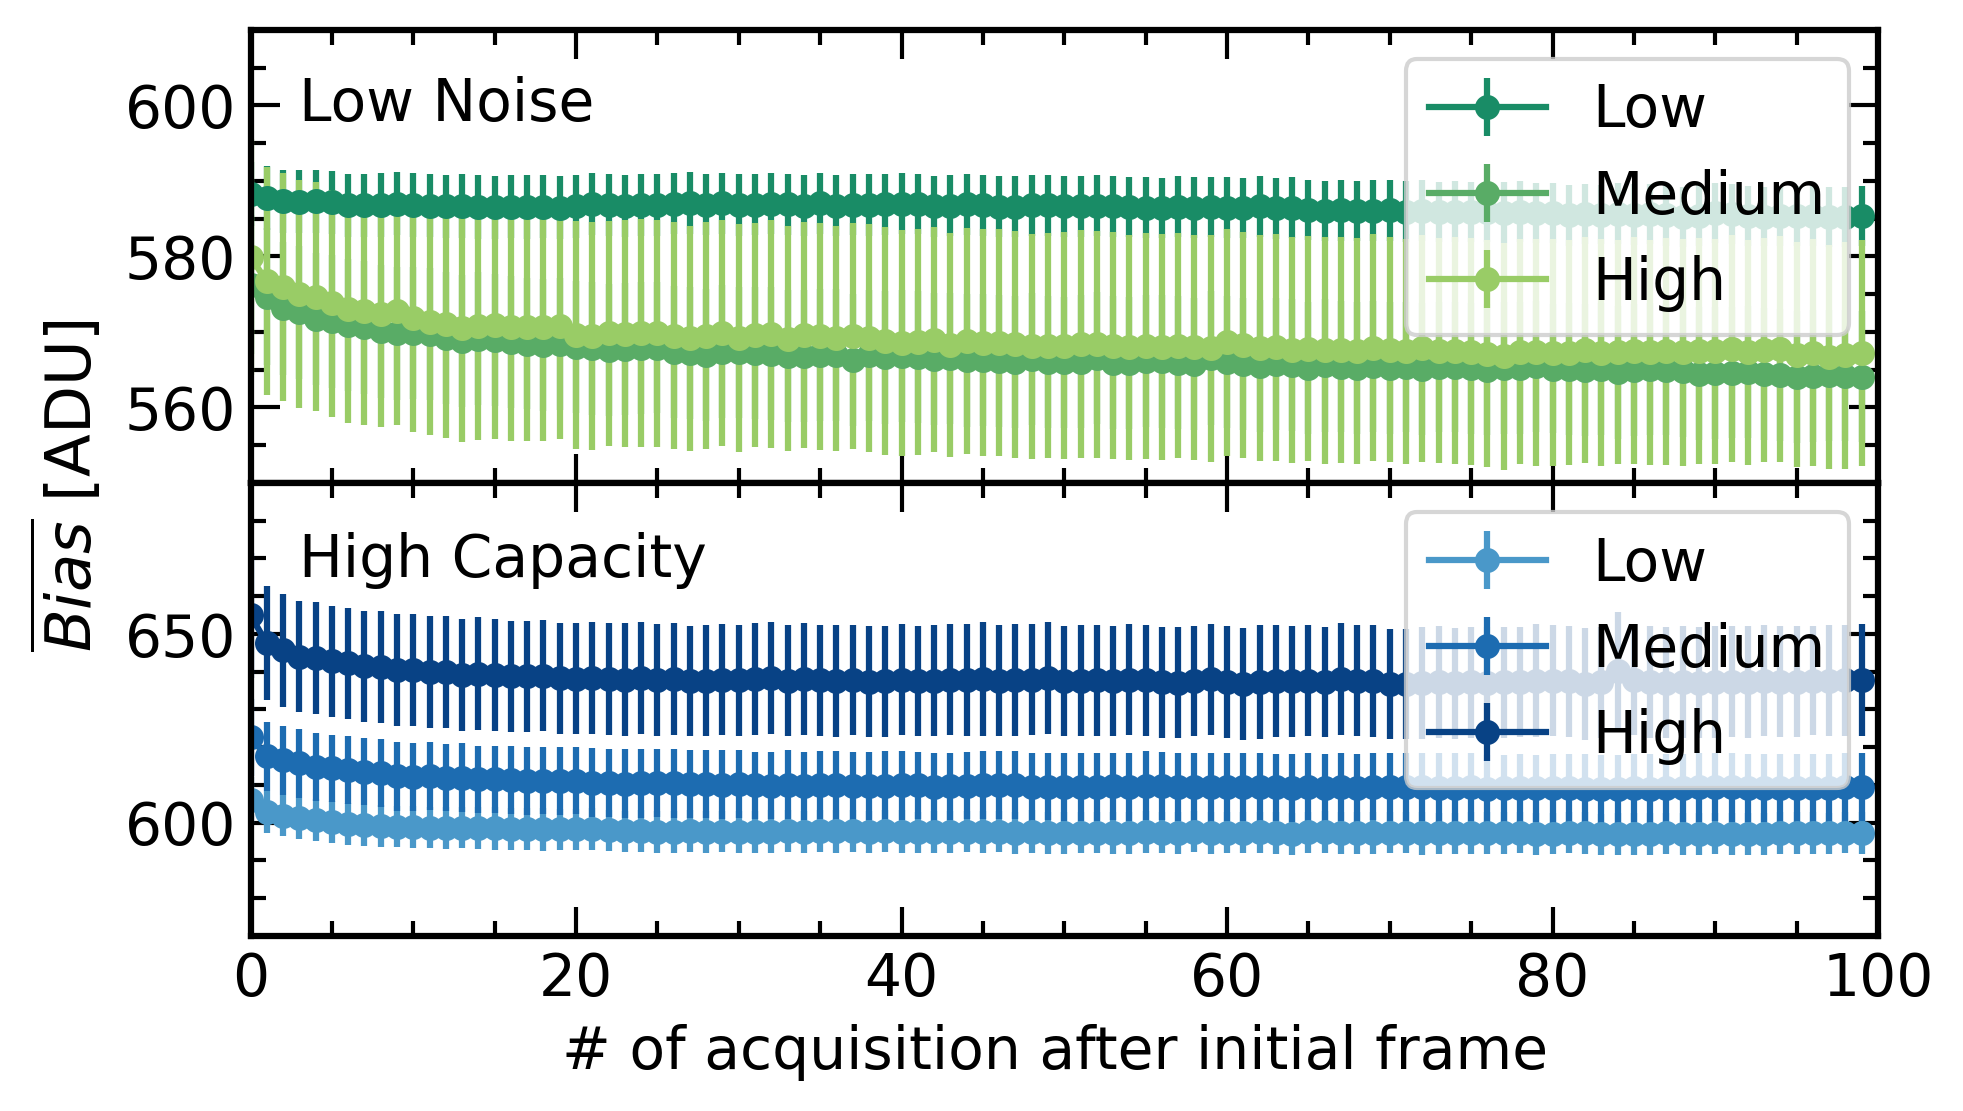

In [19]:
#Plot 
gs = GridSpec(nrows=2,ncols=1,hspace=0)

num = np.arange(0,100)
xt = np.arange(0,120,20)
fig = plt.figure(figsize=(7,4),dpi=300)

# Mean Bias level variation about time
#different acquisiton modes(Hign Capacity/Low Noise)
plt.subplot(gs[0])
for i in range(len(gain)):
    plt.errorbar(num,M[i],yerr=S[i],color=cm.summer(i/4+0.1),label=gain[i],marker='o',ms=5)
plt.text(3,598,'Low Noise')
plt.xlim(0,100)
plt.ylim(550,610)
plt.xticks(xt,[' ' for i in range(len(xt))]) 
plt.legend(loc='upper right',frameon=True)

plt.subplot(gs[1])
for i in range(3,6):
    plt.errorbar(num,M[i],yerr=S[i],color=cm.Blues(i/6+0.1),label=gain[i-3],marker='o',ms=5)
plt.xlabel('# of acquisition after initial frame ')
plt.xlim(0,100)
plt.ylim(570,690)
plt.text(3,665,'High Capacity')
plt.legend(loc='upper right',frameon=True)

fig.supylabel('$\\overline{Bias}$ [ADU]',fontsize=15)
#plt.savefig(fig_path/'Bias_stability.png',dpi=300,bbox_inches='tight')

## 3) Readout Noise

### 3-1) Single Frame Statistics

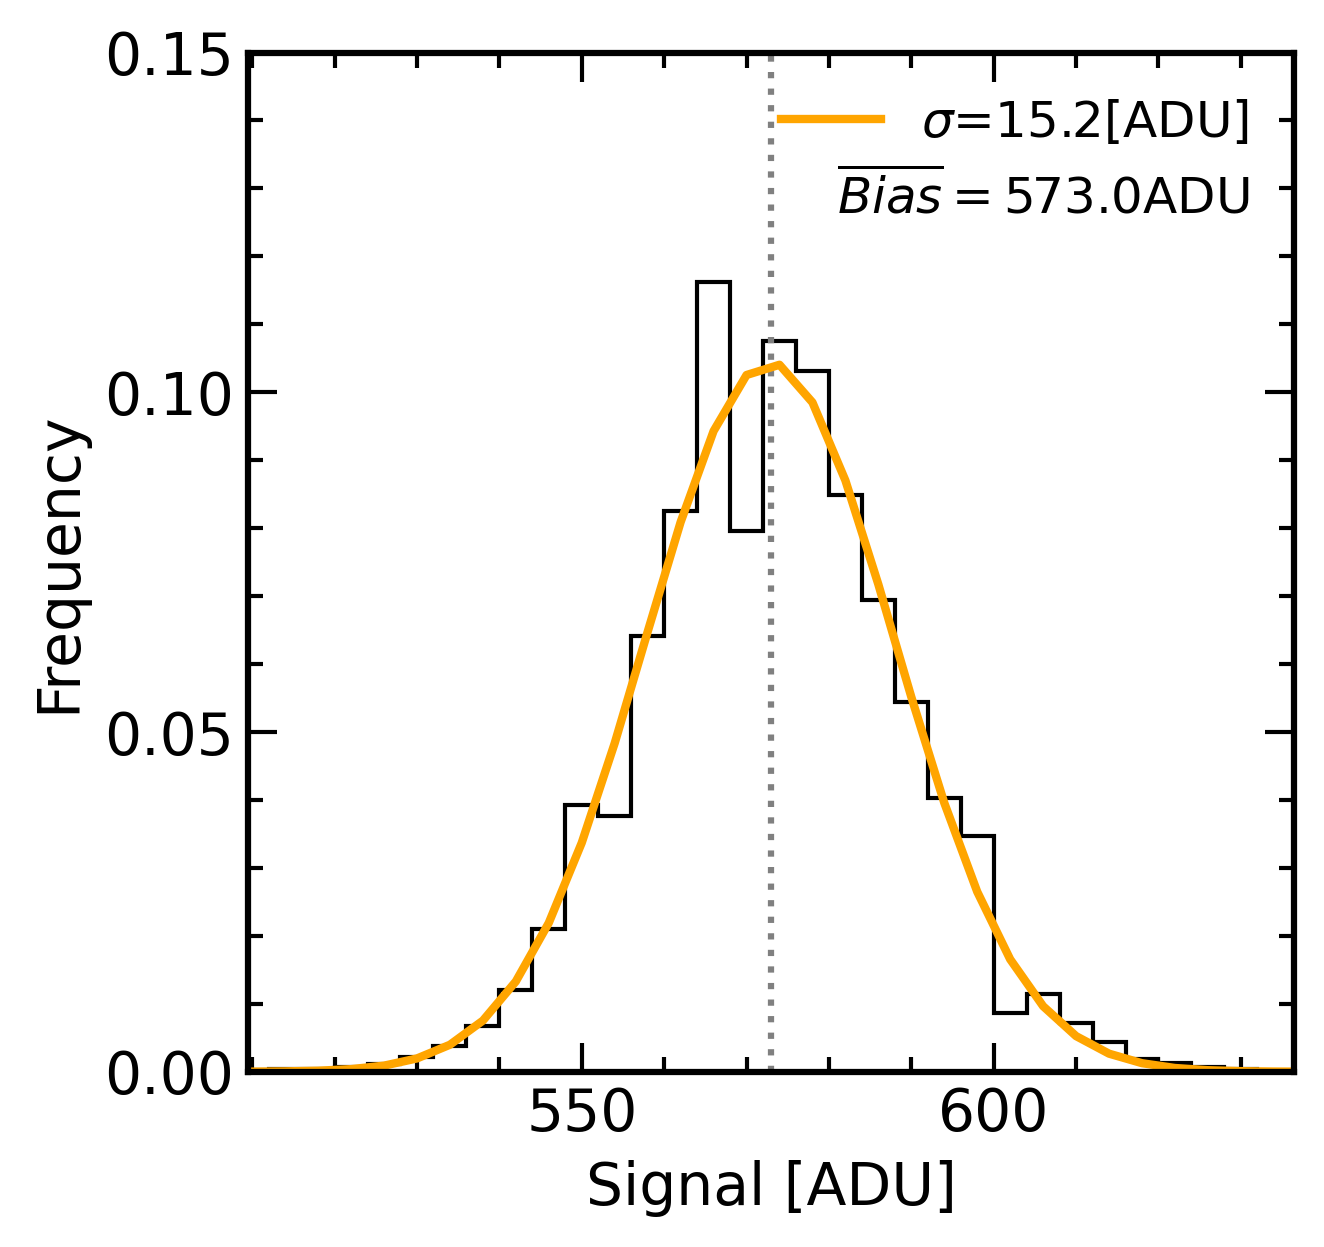

In [23]:
plt.figure(figsize=(4.5,4.5), dpi=300)
k=2
rand = np.random.randint(0,len(ubias_tot[k]))
b = np.reshape(ubias_tot[k][rand],(-1,1))
freq,bins,_ = plt.hist(b,bins=50,range=(500,700),histtype='step',color='k',weights=np.ones(len(b))/len(b))
binc = 0.5*(bins[1:]+bins[:-1])
plt.axvline(np.median(b),ls='dotted',color='gray')

data = Data(binc,freq)
#tarr=np.linspace(min(time),max(time))

b_median, b_std = np.median(b), np.std(b)
model=Model(normal_odr)
odrfit=ODR(data,model,beta0=[1,b_median,b_std]) #Beta0 : initial condition
fit=odrfit.run() #fitting process => Beta, Residual...

plt.plot(binc,normal_odr(fit.beta,binc),color='orange',label=f'$\\sigma$={fit.beta[2]:.1f}[ADU]',lw=2)
plt.xlabel("Signal [ADU]")
plt.ylabel("Frequency")
plt.text(b_median+8,1.21*fit.beta[0]
         ,s='$\\overline{Bias}=$'+f'{b_median}ADU',fontsize=12)
plt.yticks(np.arange(0,0.2,0.05))
plt.xlim(b_median-4*b_std,b_median+4*b_std)
plt.legend(fontsize=12)

#plt.savefig(fig_path/'bias_stats.png', bbox_inches="tight")

### 3-2) Multiple Frame Statistics

In [6]:
ubias_mean_tot, ubias_std_tot = [], []
k=0
for acq in acquisition:
    for g in gain:
        #For the faster calculation, you need GPU in your system.
        mean_tmp, std_tmp = calc_difference(ubias_tot[k]) 
        ubias_mean_tot.append(mean_tmp)
        ubias_std_tot.append(std_tmp)
        print(f"{acq}_{g} / Readout Noise = {np.median(std_tmp):.3f}ADU") #Median Value of Readout Noise
        k+=1

100%|█████████████████████████████████████████████████████████████████████████████████| 99/99 [04:51<00:00,  2.95s/it]


LN_Low / Readout Noise = 3.917ADU


100%|█████████████████████████████████████████████████████████████████████████████████| 99/99 [04:56<00:00,  2.99s/it]


LN_Medium / Readout Noise = 7.567ADU


100%|█████████████████████████████████████████████████████████████████████████████████| 99/99 [04:45<00:00,  2.89s/it]


LN_High / Readout Noise = 13.772ADU


100%|█████████████████████████████████████████████████████████████████████████████████| 99/99 [05:21<00:00,  3.25s/it]


HC_Low / Readout Noise = 2.686ADU


100%|█████████████████████████████████████████████████████████████████████████████████| 99/99 [04:57<00:00,  3.00s/it]


HC_Medium / Readout Noise = 4.859ADU


100%|█████████████████████████████████████████████████████████████████████████████████| 99/99 [05:12<00:00,  3.16s/it]

HC_High / Readout Noise = 9.379ADU


### a) Low Noise Mode

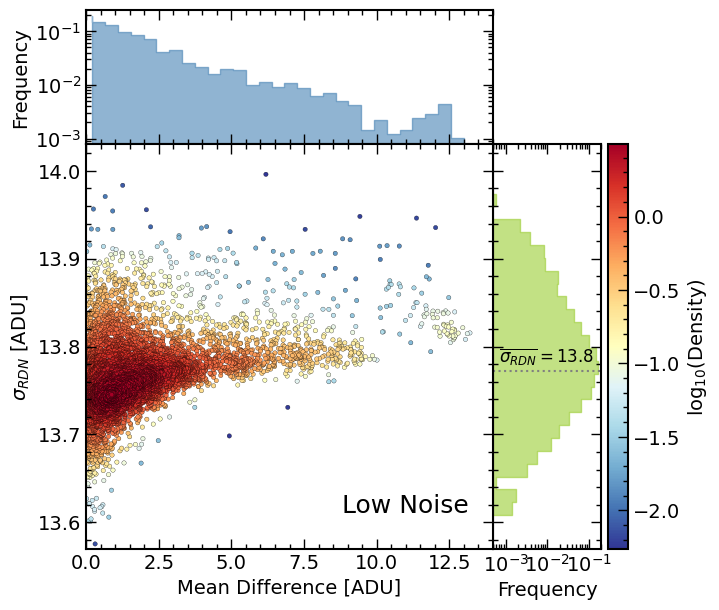

In [29]:
x, y = ubias_mean_tot[2], ubias_std_tot[2]
freq=draw_rdn_plot(x, y,label='Low Noise', fm = 0.94, fM = 1.003 )
#plt.savefig(fig_path/'RDN_LowNoise_unilum.png',dpi=300)

### b) High Capacity Mode

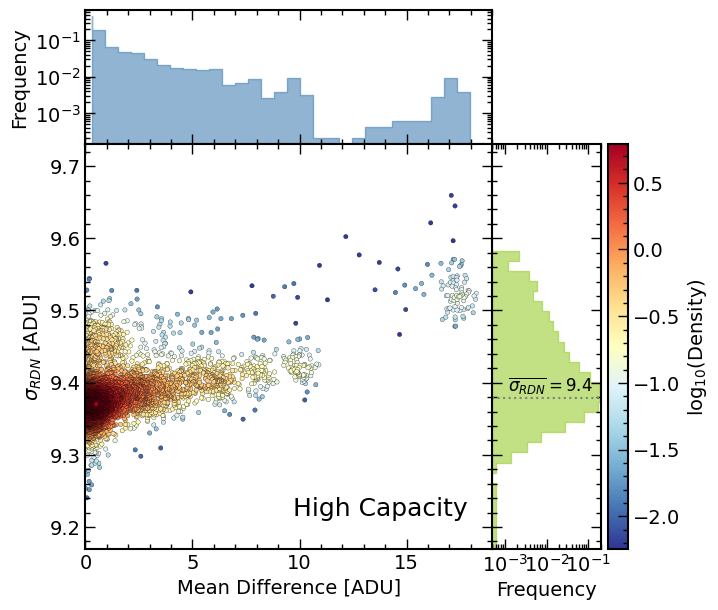

In [32]:
x, y = ubias_mean_tot[5], ubias_std_tot[5]
draw_rdn_plot(x, y,label='High Capacity', fm = 0.94, fM = 1.005)
#plt.savefig(fig_path/'RDN_HighCap_unilum.png',dpi=300)

## Photon noise

In [33]:
acquisition = ['LN']
gain = ['High'] #Reccomend for testing under High-gain mode (G = 1e/ADU)

print("== Load frames ==")
ubias_tot, bias_tot = [], []
for acq in acquisition:
    for g in gain:
        ubias, bias = [], []
        #Bias frame without light
        ubias_path = phot_path / f"unilluminated\\{acq}_{g}\\"
        ubias_list = list(ubias_path.glob('frame0000_*_b.txt'))
        
        #Bias frame with light
        bias_path = phot_path / f"illuminated\\{acq}_{g}\\"
        bias_list = list(bias_path.glob('frame0000_*_b.txt'))
        
        #Load Data file with Threading
        ubias = frame_bulk_loader(ubias_list, label=f'{acq}_{g}(Unilluminated)')
        bias = frame_bulk_loader(bias_list, label=f'{acq}_{g}(Illuminated)')

        ubias_tot.append(ubias)
        bias_tot.append(bias)

== Load frames ==


LN_High(Illuminated): 100%|██████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.10it/s]


In [34]:
#Calculate Statistics
ubias_mean_tot, ubias_std_tot = [], []
bias_mean_tot, bias_std_tot = [], []
k=0
for acq in acquisition:
    for g in gain:
        mean_ubias, std_ubias = calc_difference(ubias_tot[k])
        mean_bias, std_bias = calc_difference(bias_tot[k])

        ubias_mean_tot.append(mean_ubias)
        ubias_std_tot.append(std_ubias)
        print(f"{acq}_{g} / Readout Noise(Unilluminated) = {np.median(std_ubias):.3f}ADU") #Median Value of Readout Noise

        bias_mean_tot.append(mean_bias)
        bias_std_tot.append(std_bias)
        print(f"{acq}_{g} / Readout Noise(Illuminated) = {np.median(std_bias):.3f}ADU") 
        
        k+=1

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.07it/s]

LN_High / Readout Noise(Unilluminated) = 13.671ADU
LN_High / Readout Noise(Illuminated) = 104.765ADU


### a) Complete Darkness

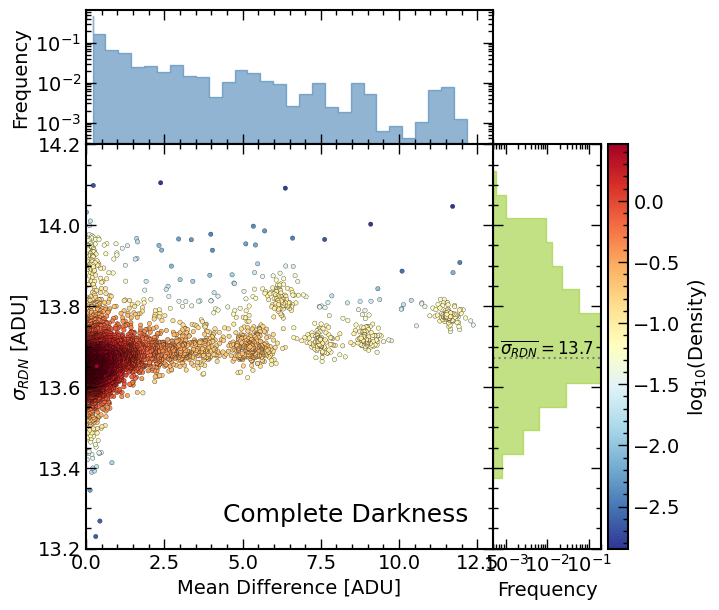

In [54]:
x, y = ubias_mean_tot[0], ubias_std_tot[0]
freq=draw_rdn_plot(x, y,label='Complete Darkness', fm = 0.94, fM = 1.005, std_bound = (13.2,14.2))
plt.savefig(fig_path/'RDN_LN_CompleteDark.png',dpi=300, bbox_inches='tight')

### b) Under Illumination

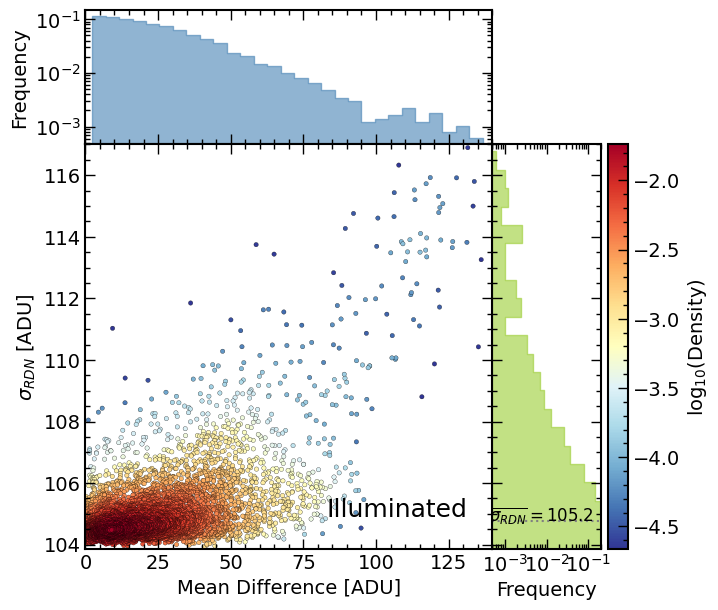

In [56]:
x, y = bias_mean_tot[0], bias_std_tot[0]
freq=draw_rdn_plot(x, y,label='Illuminated',fM=1.01,std_bound=(0,117))
plt.savefig(fig_path/'RDN_LN_HighIllum.png',dpi=300, bbox_inches='tight')

# 2. Dark Characteristics
Take frames with different exposure times sequentially. <br>
For successive measurements, exposure might be longer than 30s. <br>
Dark current is supposed to increase linearly over time, so it is recommended that you obtain a frame with the same time interval. 

In [7]:
#Load dark frames
bias,dark = [], []
tarr = []

darklist = list(dark_path.glob('*degC'))
Tarr = np.zeros(len(darklist)) #Testing Sensor Temperature

print("== Load frames ==")
for k in range(len(darklist)):
    dark_frame_list = list((darklist[k] / "single").glob("frame*.txt"))
    hdrs, dark_tmp = frame_bulk_loader(dark_frame_list, label=darklist[k].stem, header=True)
    Tarr[k] = hdrs['Temperature'][0]
    tarr.append(hdrs['Exposure'].values) #Exposure time array
    dark.append(dark_tmp)
    bias.append(dark_tmp[0]) # bias frame at given tempearture
    
bias = np.array(bias)
#The number of Dark frames may not equal to each sensor temperature.

== Load frames ==


-5degC: 100%|█████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.31it/s]


## Interline pattern noise

In [8]:
dk = dark[-1][7] #t=300s
bs = bias[-1]
dk_reshape = dk.reshape(-1)

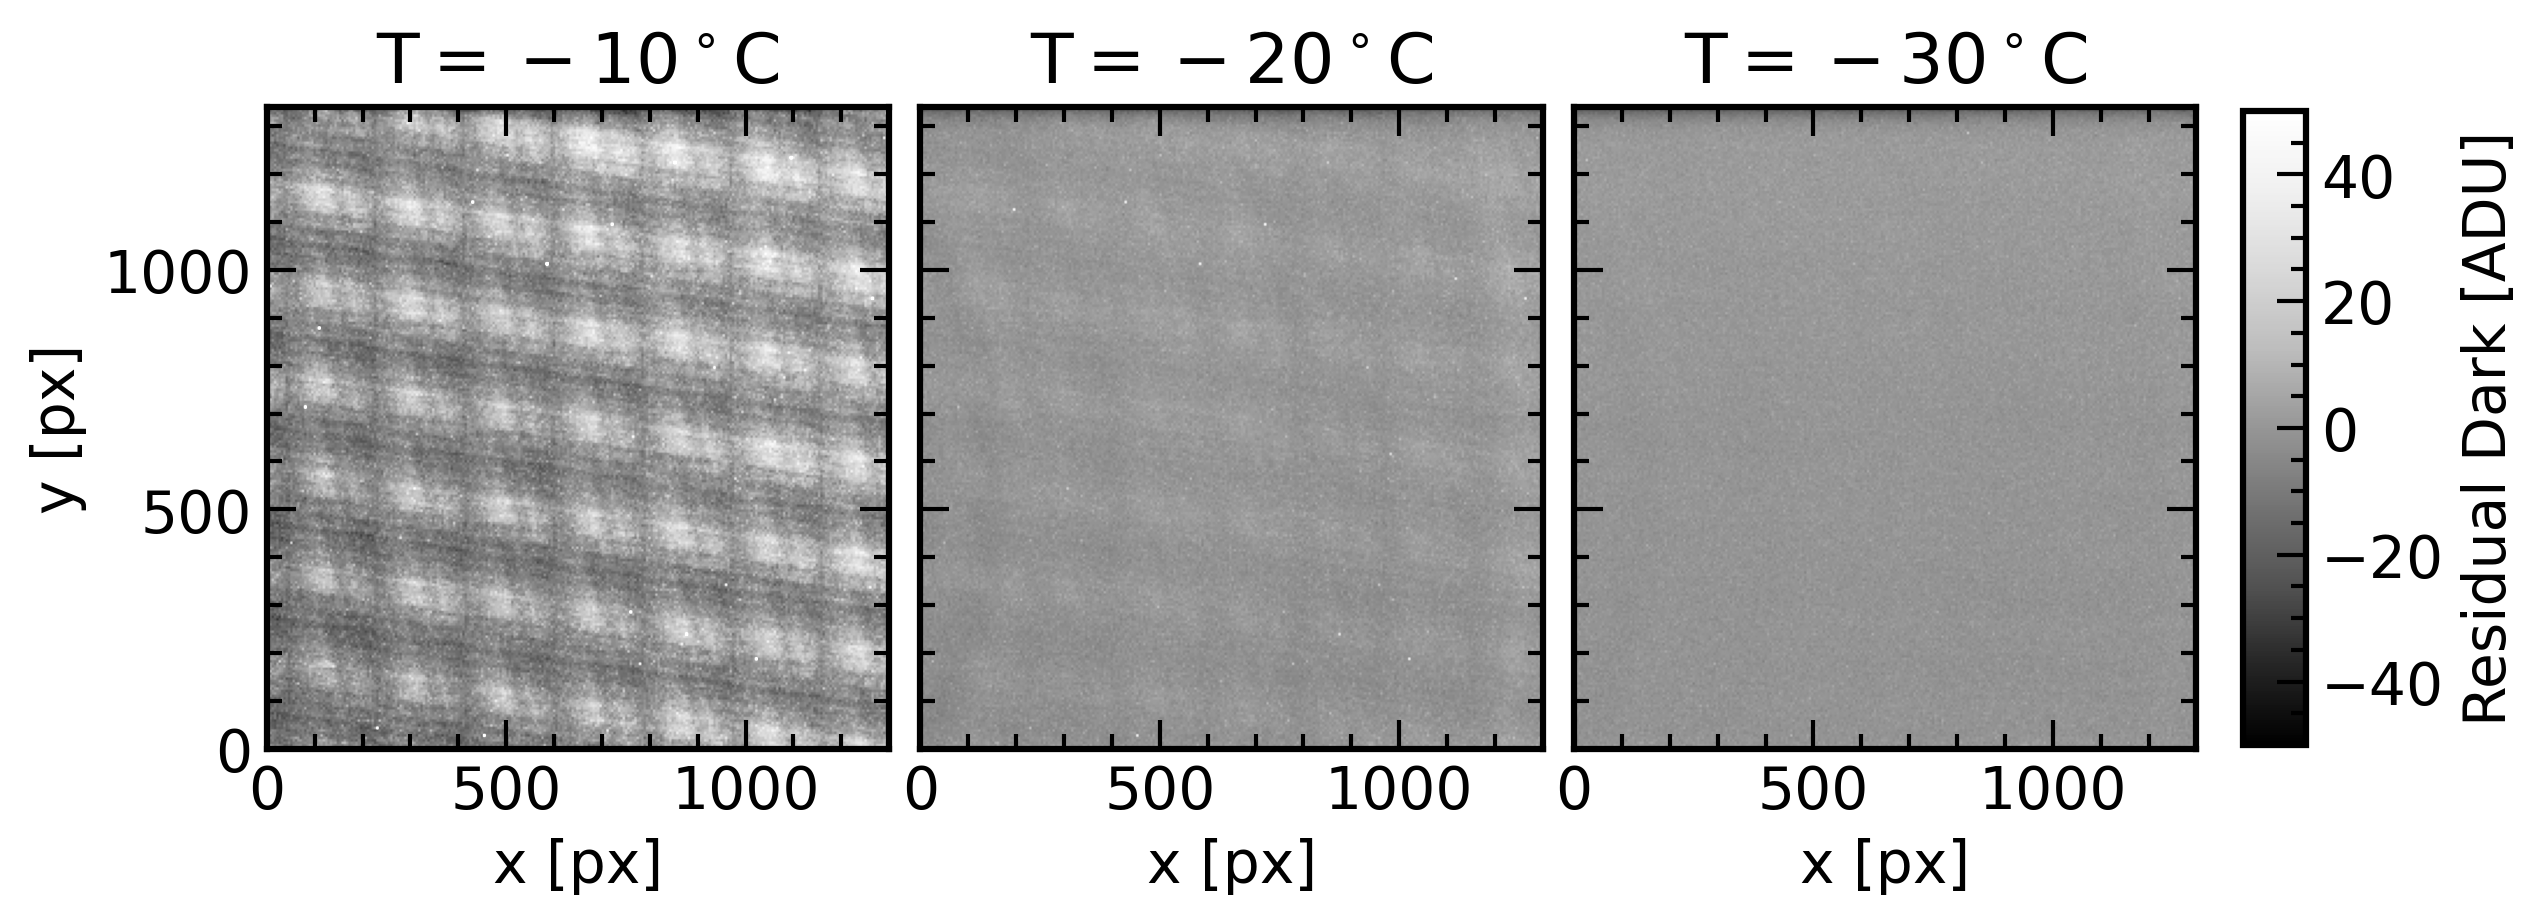

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4), dpi=300)
tmpT = []
for i, k in enumerate([1,3,5]):
    tmpT.append(int(Tarr[k]))
    binned = binning(dark[k][6] - dark[k][0])
    im = ax[i].imshow(binned-np.median(binned), cmap='Greys_r',
                      vmin=-50, vmax=50, extent=(0, Nrow, 0, Ncol))
    ax[i].set_title(f'$\\rm T={tmpT[i]}^\circ C$')
    if i==0: ax[i].set_ylabel('y [px]')
    else: ax[i].set_yticklabels('')
    ax[i].set_xlabel('x [px]')

plt.subplots_adjust(wspace = 0.05)

cbar = fig.colorbar(im, ax=ax.ravel().tolist(),shrink=0.7, aspect = 10, pad=0.02)
cbar.set_label('Residual Dark [ADU]') 

#plt.savefig(fig_path / f'Interline_{min(tmpT)}_{max(tmpT)}.png',dpi=300,bbox_inches='tight')

### Bias level Temperature dependancy

In [11]:
#Mean intensity variation
mean_bias,median_bias,std_bias=sigma_clipped_stats(bias.reshape(-1,Ncol*Nrow),sigma=3.0,axis=1)

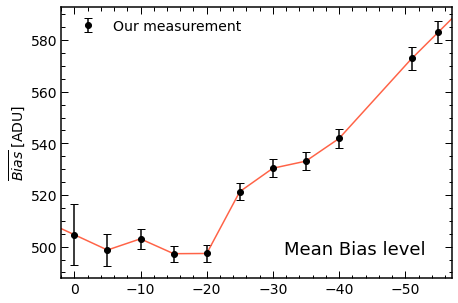

In [12]:
Ts=np.linspace(min(Tarr)-2,max(Tarr)+2,1000)
fbT = interp1d(Tarr,mean_bias,kind=1,fill_value='extrapolate')

plt.errorbar(Tarr,mean_bias,yerr=std_bias,linestyle='None',capsize=4,color='k',marker='o',label='Our measurement')
plt.plot(Ts,fbT(Ts),color='tomato')
plt.ylabel('$\\overline{Bias}$ [ADU]')
plt.yticks([500,520,540,560,580])
plt.text(-53,497,s='Mean Bias level',horizontalalignment='right',fontsize=18)
plt.xlim(2,-57)
plt.legend()

### Dark current measurment

In [40]:
DarkCurrent, DarkCurrent_err= np.zeros(len(Tarr)), np.zeros(len(Tarr))
ts=np.linspace(0, 600,100)
 
for k in tqdm(range(len(Tarr))):
    dark_biassub = dark[k]-bias[k]
    darr = dark_biassub.reshape(-1,Ncol*Nrow)
    mean,median,std=sigma_clipped_stats(darr,sigma=3.0, axis=1)
    
    #Linear Fitting
    popt,pcov=curve_fit(linear,tarr[k],mean,p0=[0,0])
    perr = np.diag(np.sqrt(pcov))
    DarkCurrent[k],DarkCurrent_err[k] =popt[0], perr[0]
    
    plt.errorbar(tarr[k], mean, yerr=std, linestyle='None',capsize=2,color='black',marker='o')
    plt.plot(ts,linear(ts,*popt),color='red',label=f"T={Tarr[k]}"+"$^{\\circ}C$ ($\\frac{dN}{dt}=$"+f"{popt[0]:.2f})")
    
plt.title("Dark Current")
plt.xlabel('Exposure time(s)')
plt.ylabel('ADU')
plt.legend(fontsize=8, bbox_to_anchor=(1.04, 1))
plt.show()

  0%|                                                                                          | 0/11 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (10,1300,1340) (3,1300,1340) 

### Temperature variation of dark current

In [14]:
kB=1.381e-23 #Boltzmann constant
gain = 4.09 #from PTC(Low Noise / Low Gain)

#ODR(orthogonal distance regression) for Non-linear Fitting
model=Model(dark_current_func)
mask = (Tarr>-30)

data=RealData(Tarr[mask],gain*DarkCurrent[mask])
fodr=ODR(data,model,beta0=[1e11,1.3e4])
fit=fodr.run()

Ts=np.linspace(min(Tarr)-5,max(Tarr)+5,1000)
fit_val=func(fit.beta,Ts)

beta, err = fit.beta, np.sqrt(np.diag(fit.cov_beta))
Eg, dEg = beta[1]*(2*kB)/(1.602e-19), err[1]*(2*kB)/(1.602e-19) #Energy band Gap

/tmp/ipykernel_2730289/620458641.py:4: RuntimeWarning: overflow encountered in exp
  return p[0]*Tk**(3/2)*np.exp(-p[1]/Tk)


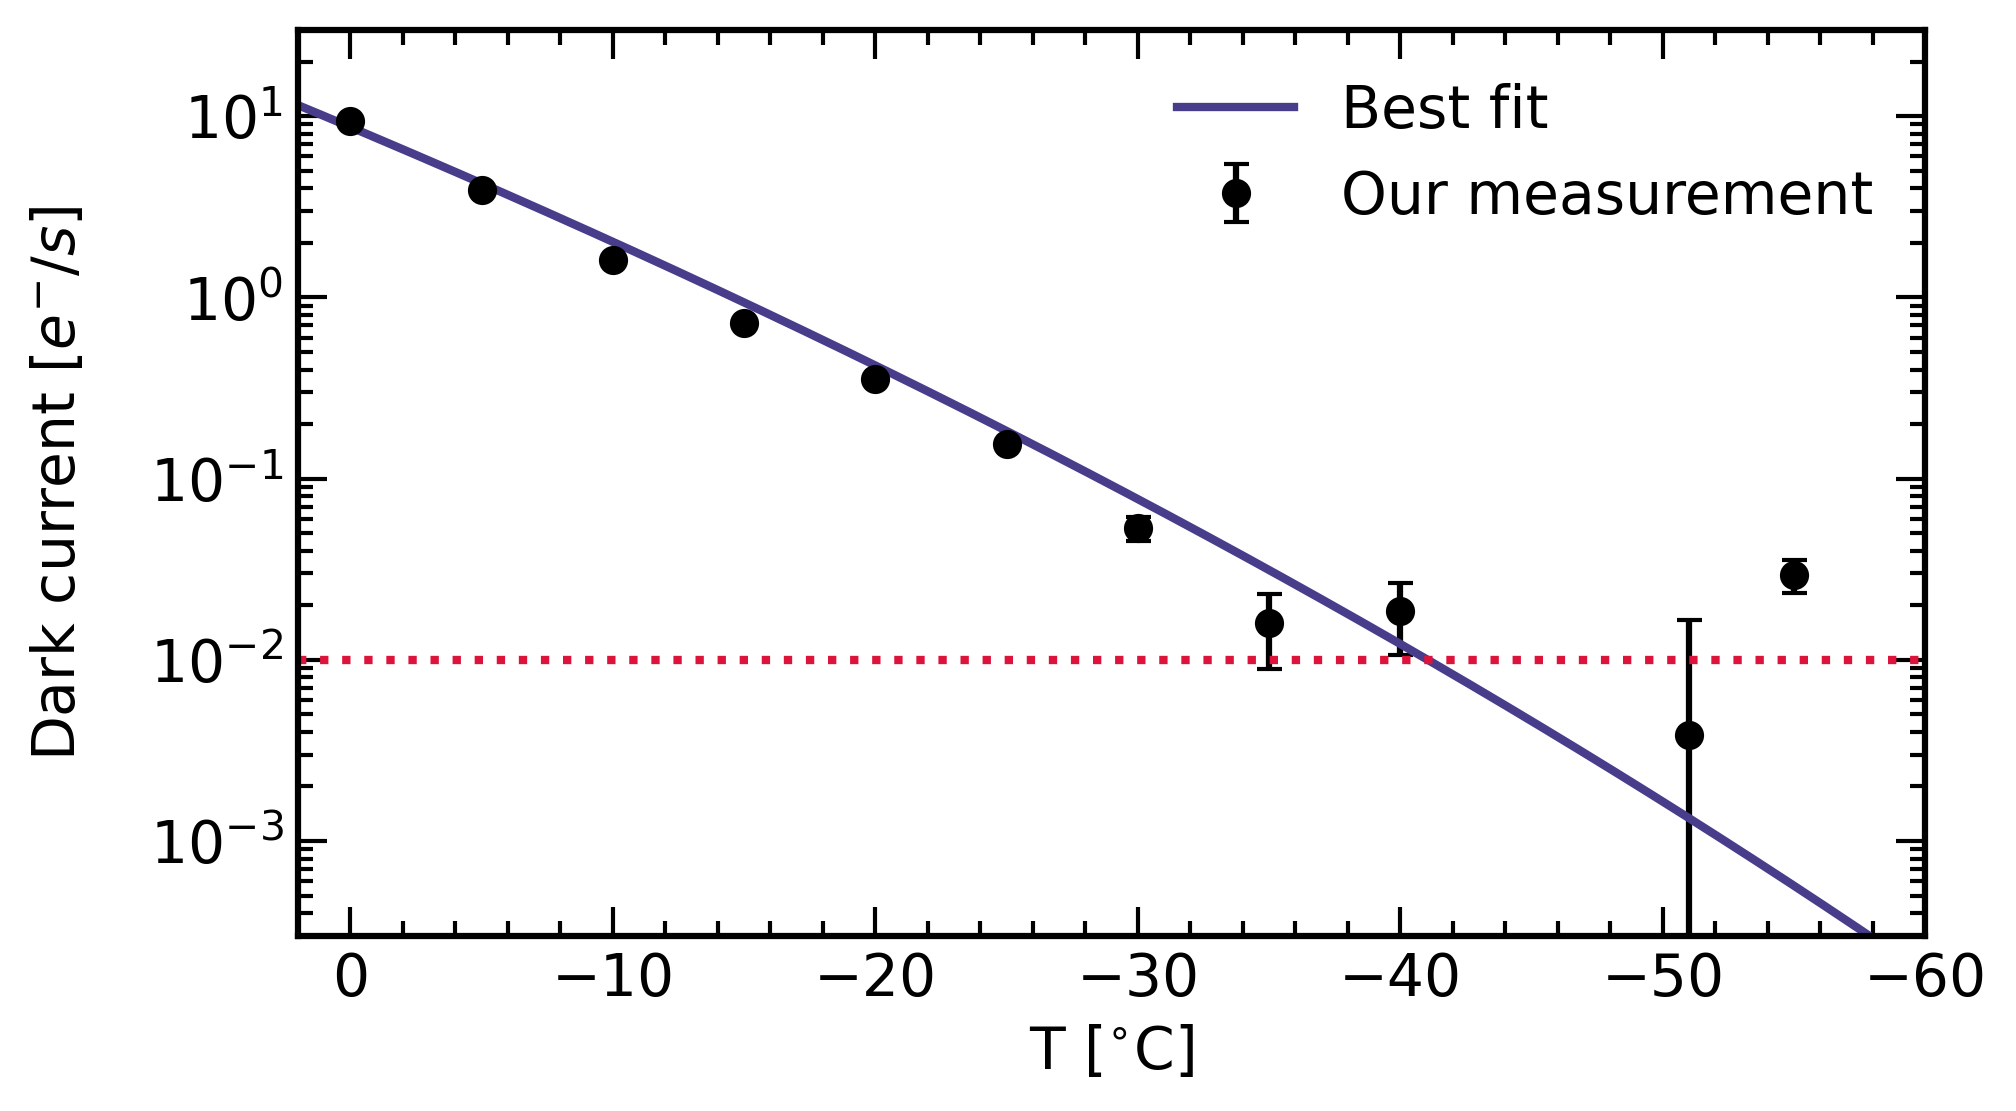

In [15]:
plt.figure(figsize=(7,4), dpi=300)
plt.errorbar(Tarr,gain*abs(DarkCurrent),yerr=gain*DarkCurrent_err,color='k',capsize=3,marker='o',ls='None',label='Our measurement')
plt.plot(Ts,fit_val,color='darkslateblue',label='Best fit',lw=2)
plt.gca().invert_xaxis()
plt.xlabel('T $\\rm[^{\\circ}C]$')
plt.ylabel('Dark current $[e^{-}/s]$',labelpad=15)
plt.xlim(2,-60)
plt.ylim(3e-4,30)
plt.axhline(1e-2,ls='dotted',color='crimson',lw=2)
#plt.text(-36,1,s='b) Dark Current', weight='bold')
plt.yscale('log')
plt.legend()
#plt.savefig('C:\\SNU\\Internship\\K-Spec\\논문\\FIgures\Dark.png',dpi=300, bbox_inches='tight')

# 3. FWC & PTC
This cells are made to measure FWC(Full Well Capacity) and PTC(Photon Transfer Curve) <br>
To obtain those curves, you should obtain frames with different illumination level. (Controling Exposure time) <br>

For FWC Measurement : First, Determine the maximal exposure time which shows saturation level(for 16bit CCD, 65535ADU).
And set proper time interval between 0s to maximal exposure time. <br> (Optional) Nearby 0s exposure, CCD may works non-lineary. Take additional frames with more finer time interval in that regime. <br>

For PTC Measurement : Short exposure is much important than FWC Measurement. Divide exposure time with logarithmic scale.
(For example, 1-10ms(1ms interval) / 10ms - 100ms(10ms interval) / 100ms-1s(100ms interval))

In [37]:
#Load flat frames
acq, g = 'LN','High'
#fwc_path = root_path / 'ex/PTC_LN_Low/600nm'
#batch_list = list(fwc_path.glob('*'))

batch_list = list((flat_path/f'{acq}_{g}').glob('*'))

print("== Load frames ==")
bias, flat, tarr = [], [], []
for batch_path in batch_list:
    if batch_path.suffix == '.txt': continue
    flat_frame_list = list(batch_path.glob('frame*.txt')) #to exclude readme.txt
    hdrs, flat_tmp = frame_bulk_loader(flat_frame_list, label=f'{acq}_{g} / batch {batch_path.stem}', header=True)
    
    Ncycle = len(hdrs[hdrs['Exposure']==hdrs['Exposure'][0]]) #the number of iterations per each exposure time
    tarr.append(np.unique(hdrs['Exposure'].values)) #Exposure time array
    flat.append(flat_tmp)
    bias.append(flat_tmp[hdrs['Exposure']==0.]) #Load illuminated bias 
    
bias = np.array(bias)
Nbatch = len(flat) #the number of division of dataset

#Load unilluminated bias
ubias_path = data_path / f"bias_unilluminated/{acq}_{g}/" 
ubias_list = list(ubias_path.glob('frame*.txt'))
ubias_hdrs, ubias = frame_bulk_loader(ubias_list, label=f'{acq}_{g} / Unilum. bias', header=True)

#Create Master bias frame
print("== Master Bias frames ==")
ubias_r = np.array(ubias).reshape(-1,Ncol*Nrow)
master_ubias,_,_ = sigma_clipped_stats(ubias_r,axis=0,sigma=3.)
master_ubias = master_ubias.reshape(Nrow,Ncol)
print('Unilluminated bias - Done')

bias_r = np.array(bias).reshape(-1,Ncol*Nrow)
master_bias,_,_ = sigma_clipped_stats(bias_r,axis=0,sigma=3.)
master_bias = master_bias.reshape(Nrow,Ncol)
print('Illuminated bias - Done')

#Gradient Correction
master_grad = master_bias-master_ubias

== Load frames ==


LN_High / Unilum. bias: 100%|███████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.65it/s]


== Master Bias frames ==
Unilluminated bias - Done
Illuminated bias - Done


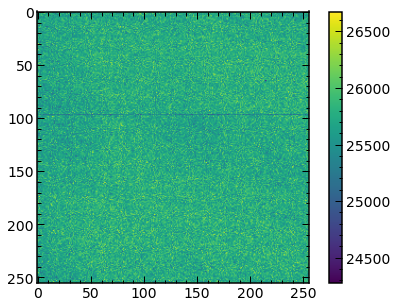

In [46]:
plt.imshow(corr_cutout)
plt.colorbar()

## Gradient Correction - Excessive Exposure Time
It is important to correct the gradiant effect by image readout process.

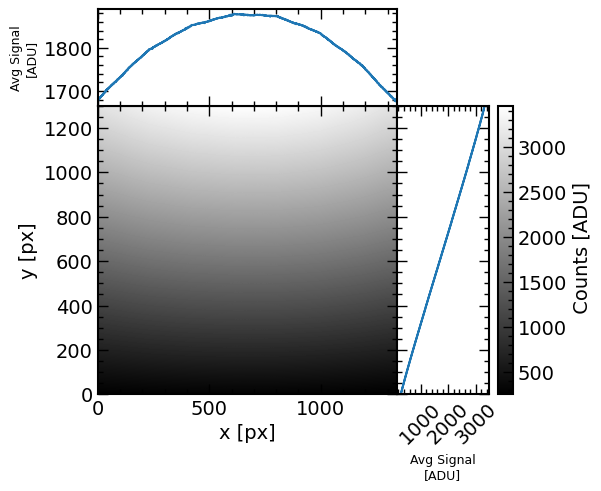

In [147]:
show_frame(master_grad)

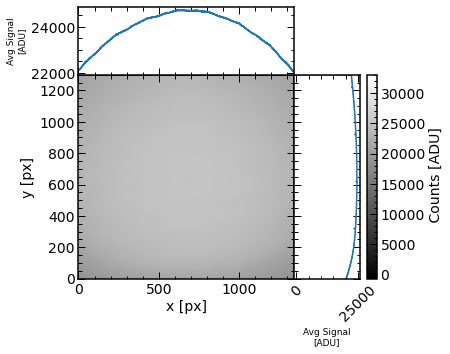

In [157]:
show_frame(diff)

(0.0, 1.2)

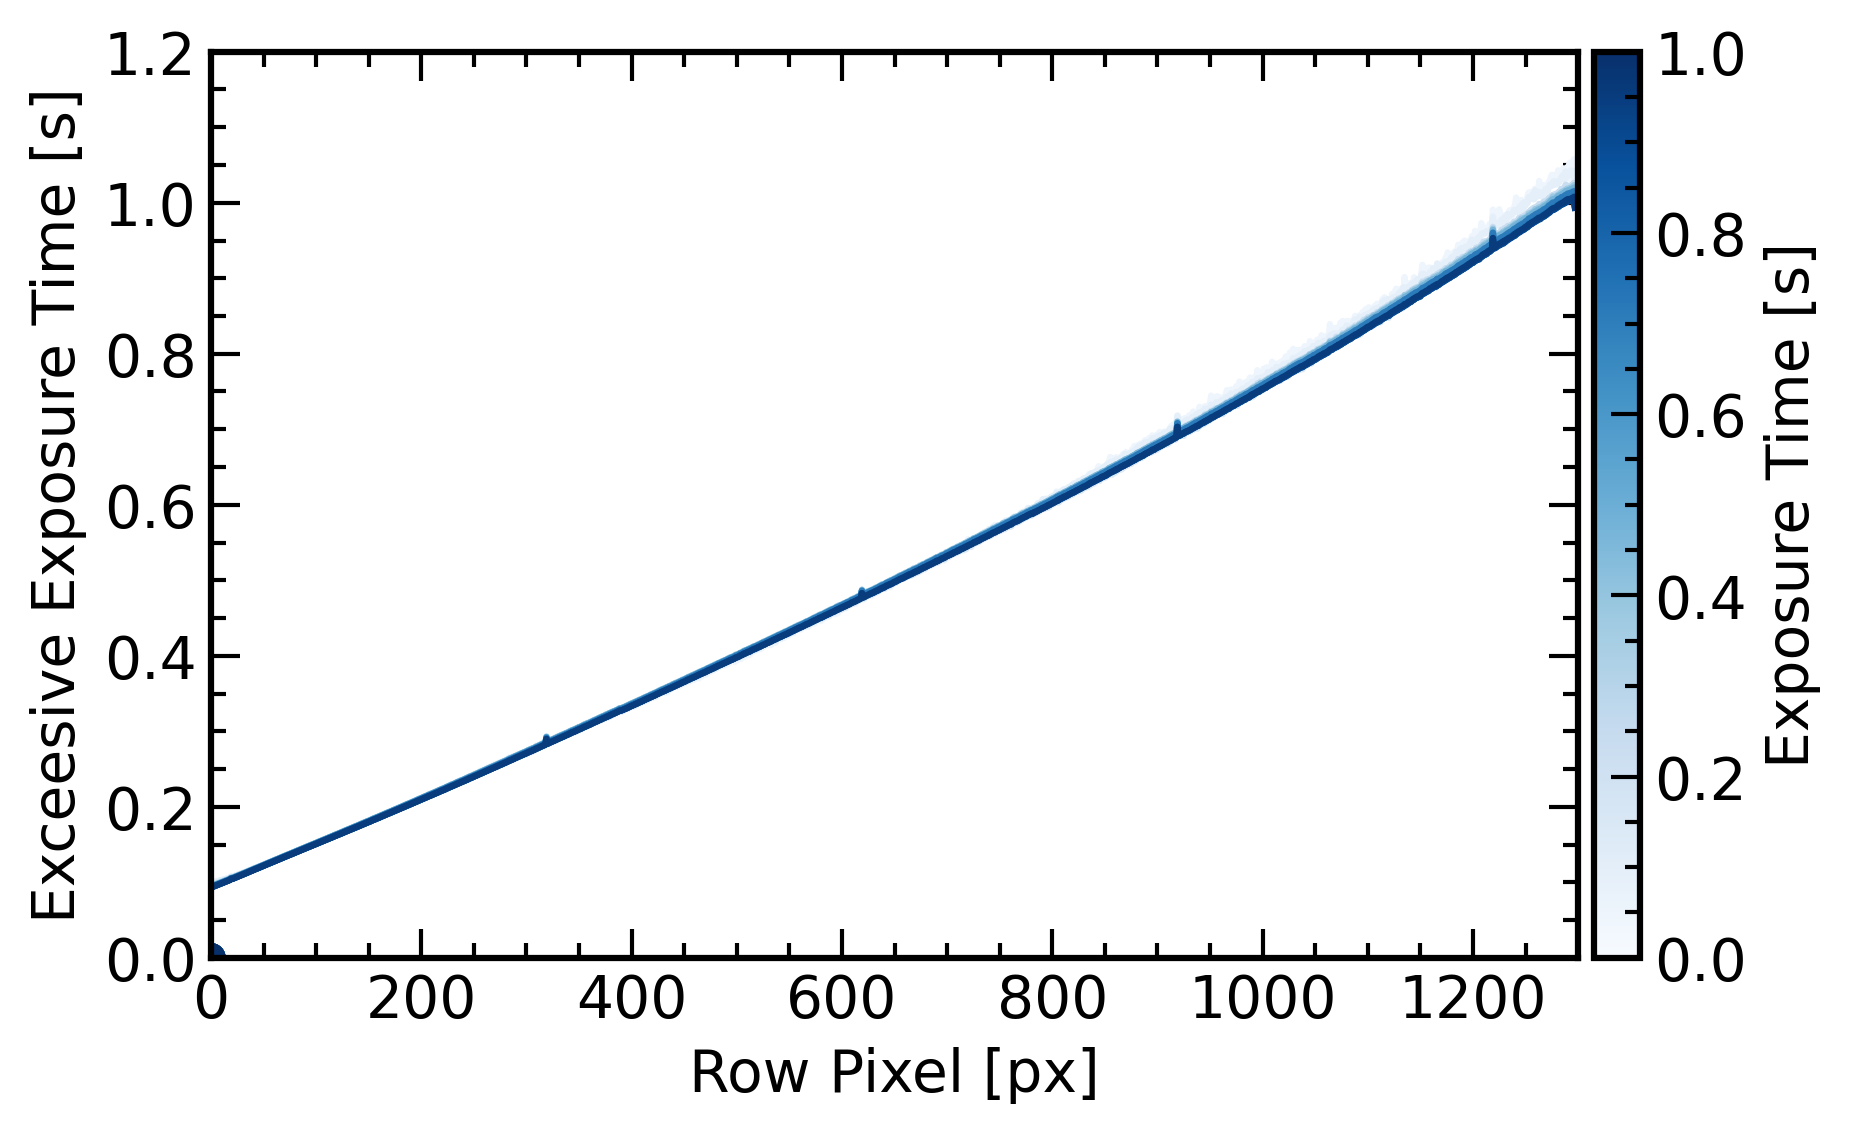

In [42]:
k=1

plt.figure(figsize=(7,4),dpi=300)
for i in range(0,len(tarr[k]),1):
    t1, t2 = tarr[k][0], tarr[k][i]
    delta = (t2-t1)/1000 #time interval between two frames
    diff = (flat[k][Ncycle*i]-flat[k][0])/(delta+1e-6)

    #Excessive Exposure TIme
    row_val,_,_=sigma_clipped_stats(master_grad/diff,axis=1)

    tmin, tmax = row_val[0], row_val[-2]
    plt.plot(row_val[:-2],color=cm.Blues(i/len(tarr[k])))#,label=f'{tarr[k][i]/1000} s')#'royalblue')

sc = plt.scatter(-10*np.zeros(len(tarr[k])),-10*np.zeros(len(tarr[k])),c=tarr[k]/1000,cmap='Blues')
plt.colorbar(sc, label='Exposure Time [s]', pad=0.01)
plt.xlabel("Row Pixel [px]")
plt.ylabel("Exceesive Exposure Time [s]")
plt.xlim(0,Nrow)
plt.ylim(0,1.2)
#plt.legend(bbox_to_anchor = (1.02,1))
#plt.text(Nrow*0.94,tmin*1.2,s=f'{acq} {g}',horizontalalignment='right',fontsize=18)
#plt.savefig(fig_path / f'Ext/ExT.png', dpi=300,bbox_inches='tight')

## Masking
To ensure uniform exposure, cutout central region.

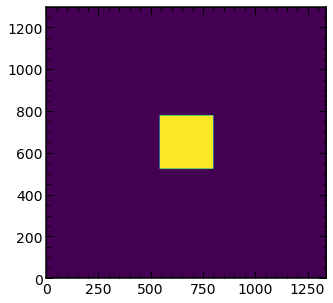

In [43]:
#Masked image (100x100 flat region)
boxsize=256
bh=boxsize//2
xcen = Ncol//2
ycen = Nrow//2
#ycen=Nrow-xcen

mask=np.zeros((Nrow,Ncol))
mask[ycen-bh:ycen+bh,xcen-bh:xcen+bh]=1
plt.imshow(mask,origin='upper',extent=(0,1340,0,1300))

### Measuring Signal($S$) & Temporal Noises($\sigma$)

#### RDN+GN

In [46]:
counts, signal, noise = [],[],[]
for n in range(Nbatch):
    for k in tqdm(range(len(tarr[n])),desc=f'Batch {n}'):
        flat_tmp = flat[n][k*Ncycle:(k+1)*Ncycle]
        C, S, N = calc_temporal_noise(flat_tmp, master_ubias, master_grad)
        counts.append(C); signal.append(S); noise.append(N)
counts, signal, noise = np.array(counts), np.array(signal), np.array(noise)

#initial conditions
p0 = np.array([1,100,0.003])
#p0=np.array([4.7,45,0.003])
#p0 = np.array([15,10,0.003])

# set proper signal range (under saturation)
mask = (10<signal)&(signal<50000) #Data Mask
#mask = (10<signal)&(signal<20000)

ptc_params, ptc_perr = fitting(total_noise,signal[mask],noise[mask],p0,bounds=[[1,1,0],[18,200,0.5]])
#ptc_params : Readout noise / Gain / P_FPN

t = np.hstack(tarr)/1000 #time array(seconds)
#sort data points
_, uidx = np.unique(t,return_index=True) #select unique datapoints
data = np.vstack([t,signal,counts])[:,uidx]
t_sorted, s_sorted, c_sorted = data[:,data[0].argsort()]

Batch 2: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.66it/s]


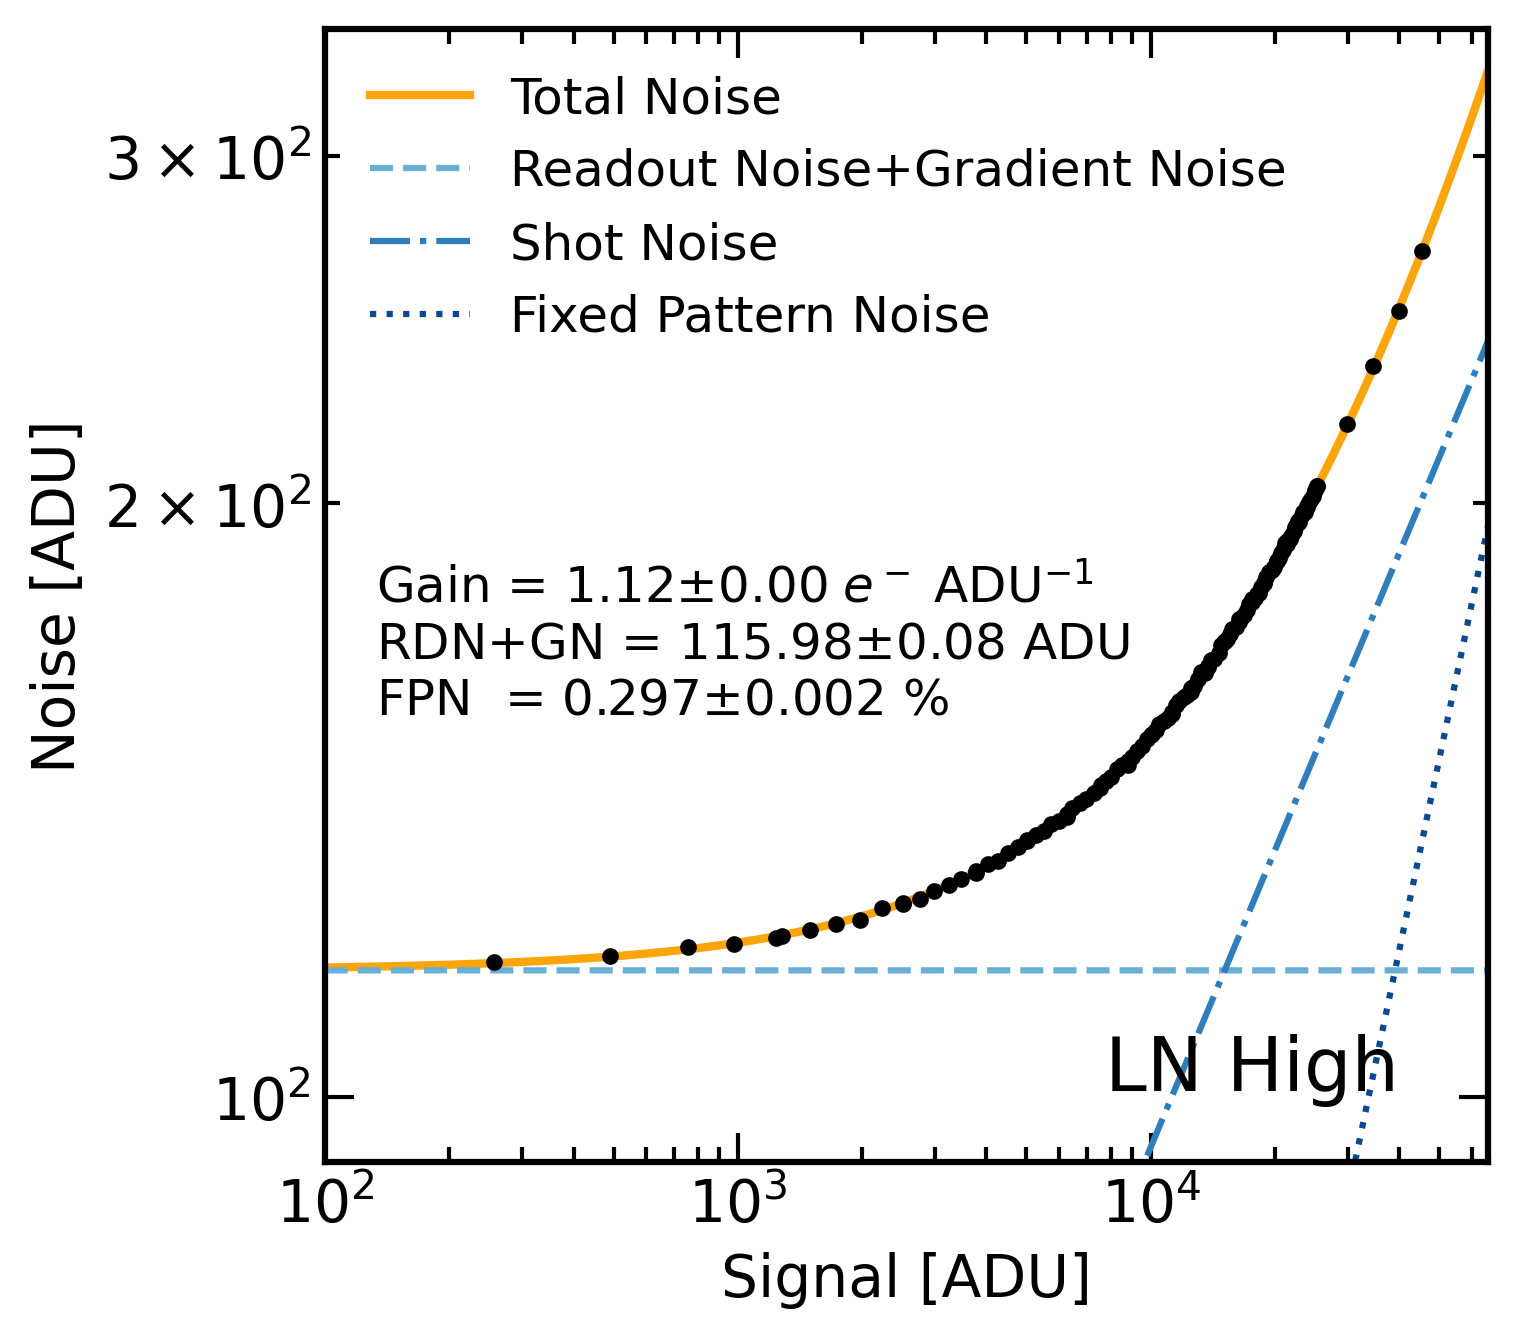

In [55]:
s=np.logspace(0,5,2000)

plt.figure(figsize=(5,5), dpi = 300, facecolor = 'white')
plt.errorbar(signal[mask],noise[mask],color='k',ms=3,capsize=3,marker='o',ls='None')
plt.plot(s,total_noise(s,*ptc_params),label='Total Noise',color=cm.inferno(0.8),lw=2)
plt.plot(s, np.ones(len(s))*ptc_params[1],label='Readout Noise+Gradient Noise',color=cm.Blues(0.5),ls='--')
plt.plot(s, np.sqrt(s/ptc_params[0]),label='Shot Noise',color=cm.Blues(0.7),ls='-.')
plt.plot(s, s*ptc_params[2],label='Fixed Pattern Noise',color=cm.Blues(0.9),ls=':')

plt.xscale('log')
plt.yscale('log')

x_lb, x_ub = 100, 65535
y_lb, y_ub = ptc_params[1]*0.8, ptc_params[1]*3
plt.xlim(x_lb, x_ub)
plt.ylim(y_lb, y_ub)
plt.xlabel("Signal [ADU]")
plt.ylabel("Noise [ADU]")

plt.text(x_lb+(x_ub-x_lb)*0.0005,y_lb+(y_ub-y_lb)*0.25,
         f"Gain = {ptc_params[0]:.2f}$\\pm${ptc_perr[0]:.2f}$\;e^-\;\\rm ADU^{{-1}}$\nRDN+GN = {ptc_params[1]:.2f}$\\pm${ptc_perr[1]:.2f} ADU\nFPN  = {ptc_params[2]*100:.3f}$\pm${ptc_perr[2]*100:.3f} %", fontsize=12)
plt.text(40000,ptc_params[1]*0.87,s=f'{acq} {g}',fontsize=18,horizontalalignment='right')

plt.legend(frameon=False,fontsize=12,loc='upper left')

#plt.savefig(f'C:\\SNU\\Internship\\K-Spec\\논문\\FIgures\\PTC_revised\\PTC_{acq}_{g}_sep.png',dpi=300, bbox_inches="tight")

#### Fixed RDN

In [ ]:
RDN = 13.77
GN  = np.sqrt(115.98**2-RDN**2)
counts, signal, noise = [],[],[]
for n in range(Nbatch):
    for k in tqdm(range(len(tarr[n])),desc=f'Batch {n}'):
        flat_tmp = flat[n][k*Ncycle:(k+1)*Ncycle]
        C, S, N = calc_temporal_noise(flat_tmp, master_ubias, master_grad, fixed_GN = GN)
        counts.append(C); signal.append(S); noise.append(N)

counts, signal, noise = np.array(counts), np.array(signal), np.array(noise)

#initial conditions
#p0=np.array([4.7,45,0.003])
p0 = np.array([1,100,0.003])
#p0 = np.array([12,10,0.003])

mask = (10<signal)&(signal<50000) #Data Mask
ptc_params, ptc_perr = fitting(total_noise,signal[mask],noise[mask],p0,bounds=[[1,1,0],[18,200,0.5]])
#ptc_params : Readout noise / Gain / P_FPN

t = np.hstack(tarr)/1000 #time array(seconds)
#sort data points
_, uidx = np.unique(t,return_index=True) #select unique datapoints
data = np.vstack([t,signal,counts])[:,uidx]
t_sorted, s_sorted, c_sorted = data[:,data[0].argsort()]


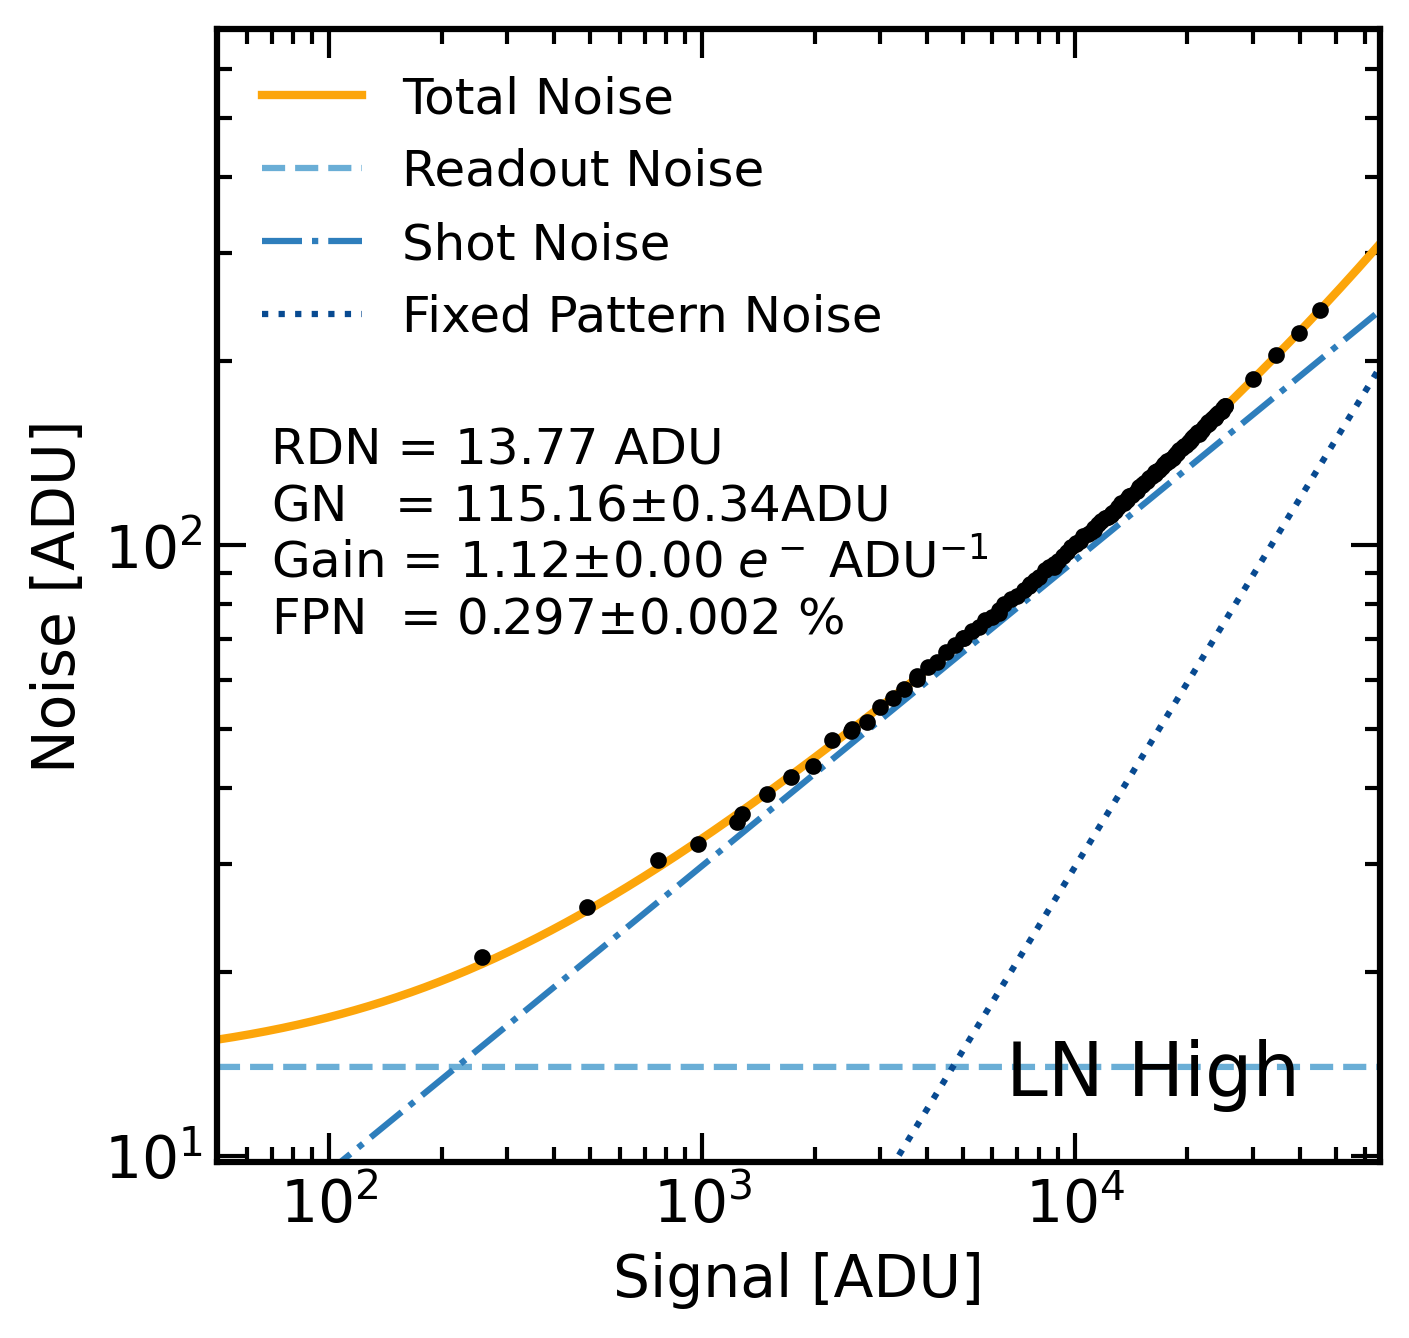

In [14]:
s=np.logspace(0,5,2000)

plt.figure(figsize=(5,5), dpi = 300, facecolor = 'white')
plt.errorbar(signal[mask],noise[mask],color='k',ms=3,capsize=3,marker='o',ls='None')
plt.plot(s,total_noise(s,*ptc_params),label='Total Noise',color=cm.inferno(0.8),lw=2)
plt.plot(s, np.ones(len(s))*ptc_params[1],label='Readout Noise',color=cm.Blues(0.5),ls='--')
plt.plot(s, np.sqrt(s/ptc_params[0]),label='Shot Noise',color=cm.Blues(0.7),ls='-.')
plt.plot(s, s*ptc_params[2],label='Fixed Pattern Noise',color=cm.Blues(0.9),ls=':')

plt.xscale('log')
plt.yscale('log')
#plt.ylim(50,500)

x_lb, x_ub = 50, 65535
y_lb, y_ub = ptc_params[1]*0.7,ptc_params[1]*50
plt.xlim(x_lb, x_ub)
plt.ylim(y_lb, y_ub)
plt.xlabel("Signal [ADU]")
plt.ylabel("Noise [ADU]")

plt.text(x_lb+(x_ub-x_lb)*0.0003,y_lb+(y_ub-y_lb)*0.09,
         f"RDN = {RDN:.2f} ADU\nGN   = {GN:.2f}$\\pm${ptc_perr[1]:.2f}ADU\nGain = {ptc_params[0]:.2f}$\\pm${ptc_perr[0]:.2f}$\;e^-\;\\rm ADU^{{-1}}$\nFPN  = {ptc_params[2]*100:.3f}$\pm${ptc_perr[2]*100:.3f} %", fontsize=12)
plt.text(40000,ptc_params[1]*0.9,s=f'{acq} {g}',fontsize=18,horizontalalignment='right')

#plt.text(x_lb+(x_ub-x_lb)*0.0005,y_lb+(y_ub-y_lb)*0.3,
#         f"Gain = {ptc_params[0]:.2f}$\\pm${ptc_perr[0]:.2f}$\;e^-\;\\rm ADU^{{-1}}$\nRDN+GN = {ptc_params[1]:.2f}$\\pm${ptc_perr[1]:.2f} ADU\nFPN  = {ptc_params[2]*100:.3f}$\pm${ptc_perr[2]*100:.3f} %", fontsize=12)
#plt.text(40000,ptc_params[1]*0.83,s=f'{acq} {g}',fontsize=18,horizontalalignment='right')

plt.legend(frameon=False,fontsize=12,loc='upper left')

##Residual 추가하기?
#plt.savefig(f'C:\\SNU\\Internship\\K-Spec\\논문\\FIgures\\PTC_revised\\PTC_{acq}_{g}_sep.png',dpi=300, bbox_inches="tight")

## FWC

### Single Linear Region

Text(0.5, 0, 'Exposure [s]')

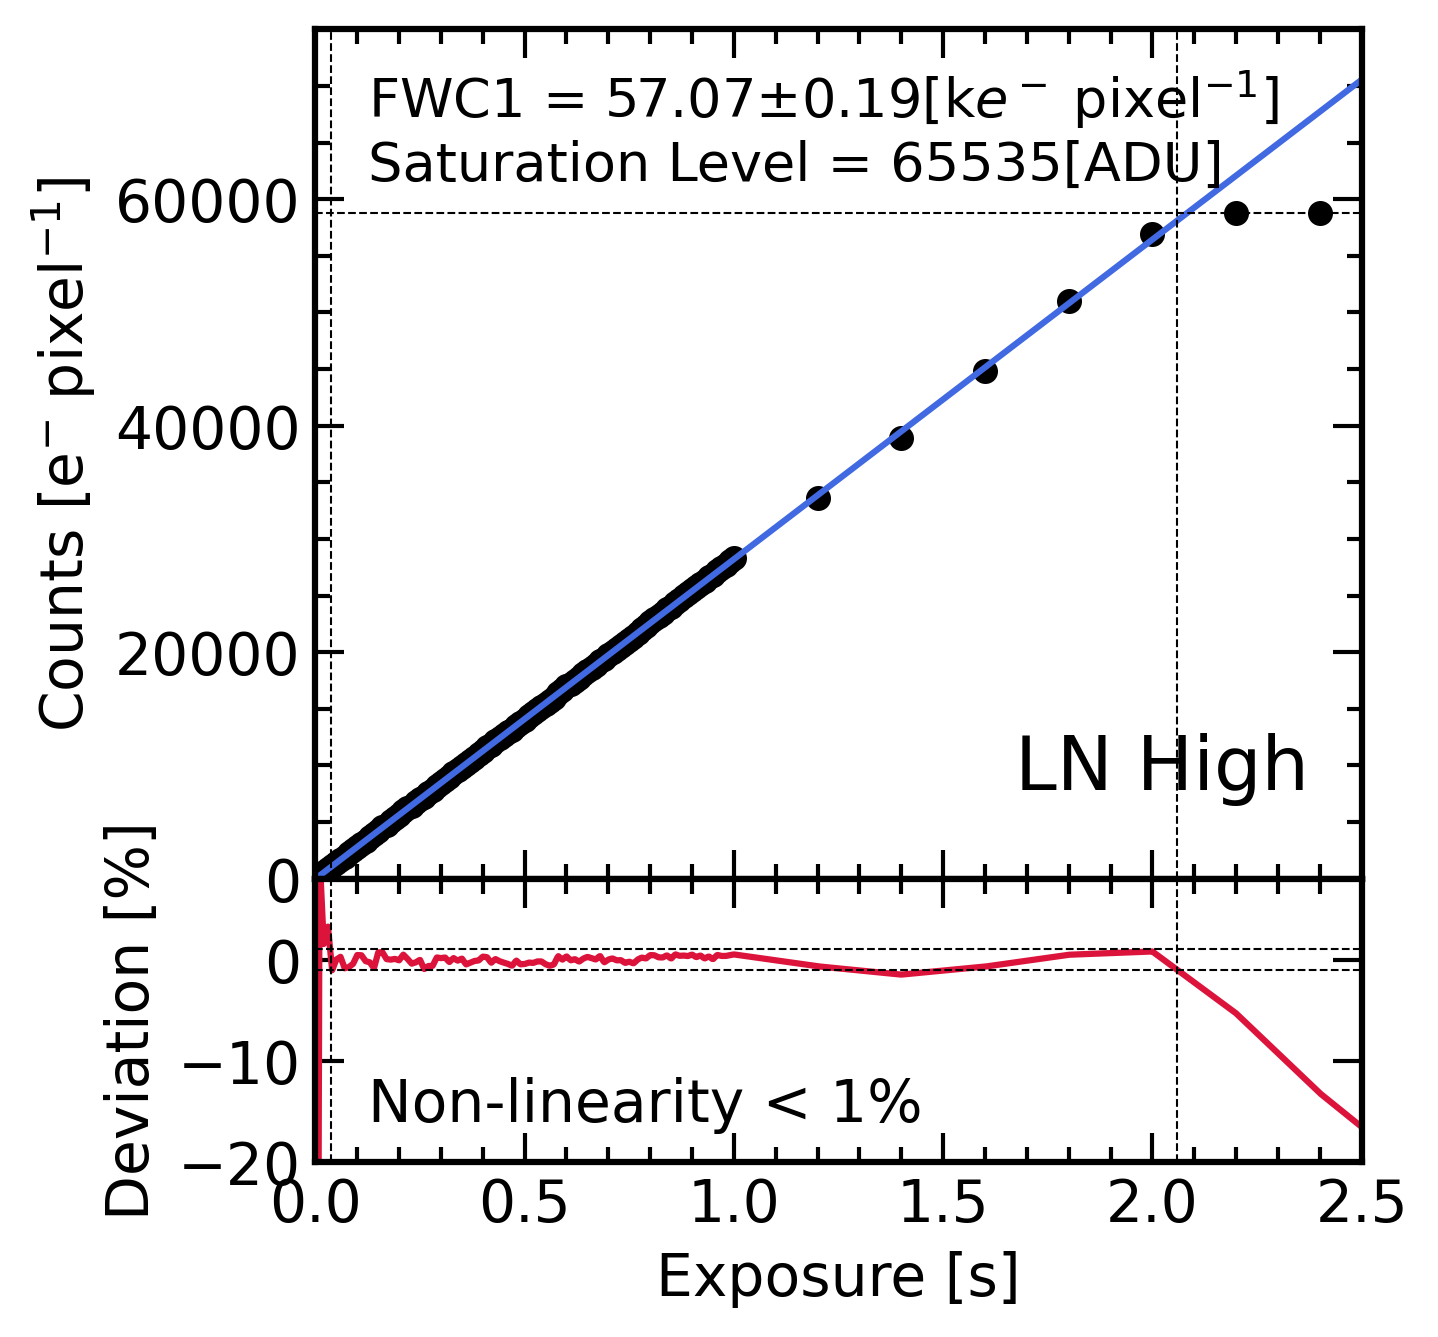

In [75]:
#Gain of CCD
G = ptc_params[0]
Gerr = ptc_perr[0]

#Linear Fitting of linear region
tmax = 2.5 #t_sorted[-1] 
mask = ((10<s_sorted)&(s_sorted<50000)&(t_sorted<tmax))
popt, pcov= curve_fit(linear,t_sorted[mask],s_sorted[mask])
perr = np.sqrt(np.diag(pcov))

linearity = 1 #linearity criteria, %
ts = np.linspace(0, tmax, 1000)

#Deviation from linear fitting
dev = (s_sorted-linear(t_sorted,*popt))/linear(t_sorted,*popt)*100
interp = interp1d(t_sorted,dev,kind=1,fill_value='extrapolate')#interpolate.CubicSpline(t,dev,bc_type='natural')
dev_ts = interp(ts)

# moving average smoothing
win = 11  # window (recomended 11-51)
kernel = np.ones(win) / win
dev_ts = np.convolve(dev_ts, kernel, mode='same')

good = np.abs(dev_ts) <= linearity

idx = np.flatnonzero(good)
if idx.size == 0:
    t_low, t_sat = np.nan, np.nan
else:
    brk = np.where(np.diff(idx) > 1)[0]
    starts = np.r_[idx[0], idx[brk + 1]]
    ends   = np.r_[idx[brk], idx[-1]]
    k = np.argmax(ends - starts) # take longest continuous interval 
    t_low = ts[starts[k]]
    t_sat = ts[ends[k]]
    
t_sat = max(ts[abs(interp(ts)+linearity)<=0.1]) #upper limit of linearity
# -----------------------------------------------

#Full Well Capacity
FWC = G*(linear(t_sat,*popt)-linear(t_low,*popt))
FWC_err = FWC*np.sqrt((Gerr/G)**2+(perr[1]/(linear(t_sat,*popt)-linear(t_low,*popt)))**2)

saturation_counts = int(max(counts))
saturation_signal = int(max(signal))
#bias_level = popt[1]

fig = plt.figure(figsize=(4.5,5), dpi = 300)
gs = GridSpec(nrows = 2, ncols =1, height_ratios = [3,1], hspace=0)

ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

#Top - Linearity curve
ax.plot(t_sorted,G*s_sorted,color='k',ls='None',marker='o',ms=5)
ax.plot(ts,G*linear(ts,*popt),color='royalblue',label='1st linear region')
ax.axvline(t_sat,ls='dashed',lw=0.5,color='k')
ax.axvline(t_low,ls='dashed',lw=0.5,color='k')
ax.axhline(G*saturation_signal,ls='dashed',color='k',lw=0.5)
ax.text(tmax*0.05,G*saturation_signal*1.05,f'FWC1 = {FWC/1e3:.2f}$\\pm${FWC_err/1e3:.2f}[k$e^-\;\\rm pixel^{{-1}}$]\nSaturation Level = {saturation_counts}[ADU]',fontsize=13)
ax.text(tmax*0.95,G*7000,s=f'{acq} {g}',fontsize=18,horizontalalignment='right')

ax.set_xlim(0,tmax)
ax.set_ylim(0,G*saturation_signal*1.25)#G*linear(ts[-1],*popt))
ax.set_ylim(0,75000)
#ax.set_yticks([50000, 150000, 250000])
ax.set_ylabel("Counts [$\\rm e^{-}\;pixel^{-1}$]")
ax.xaxis.set_tick_params(labelbottom=False)

#Bottom - Deviation from linear response
#ax2.plot(t_sorted,dev, color='crimson',marker='o',ms=3,ls='None')
ax2.plot(ts,interp(ts), color='crimson')
ax2.set_ylabel("Deviation [%]")
ax2.set_yticks([0,-10,-20])
ax2.set_xlim(0,tmax)
ax2.set_ylim(-20,8)
ax2.text(tmax*0.05,-16,f"Non-linearity < {linearity}%")
ax2.axvline(t_low,ls='dashed',lw=0.5,color='k')
ax2.axvline(t_sat,ls='dashed',lw=0.5,color='k')
ax2.axhline(linearity,color='k',ls='dashed',lw=0.5)
ax2.axhline(-linearity,color='k',ls='dashed',lw=0.5)
ax2.set_xlabel("Exposure [s]")

#plt.savefig(f'C:\\SNU\\Internship\\K-Spec\\논문\\FIgures\FWC\\{acq}\\FWC_{acq}_{g}.png', bbox_inches="tight")

### Multiple Linear Region
- High Capacity - Low, Medium mode

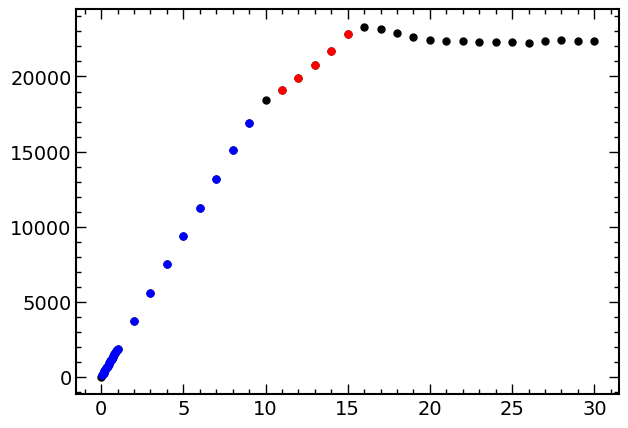

In [248]:
# check the data points to make sure the appropriate range
mask1 = ((10<s_sorted)&(s_sorted<17000)&(t_sorted<tmax))
mask2 = ((19000<s_sorted)&(s_sorted<26000)&(t_sorted<16))
plt.plot(t_sorted,s_sorted,color='k',ls='None',marker='o',ms=5)
plt.plot(t_sorted[mask1],s_sorted[mask1],color='b',ls='None',marker='o',ms=5)
plt.plot(t_sorted[mask2],s_sorted[mask2],color='r',ls='None',marker='o',ms=5)

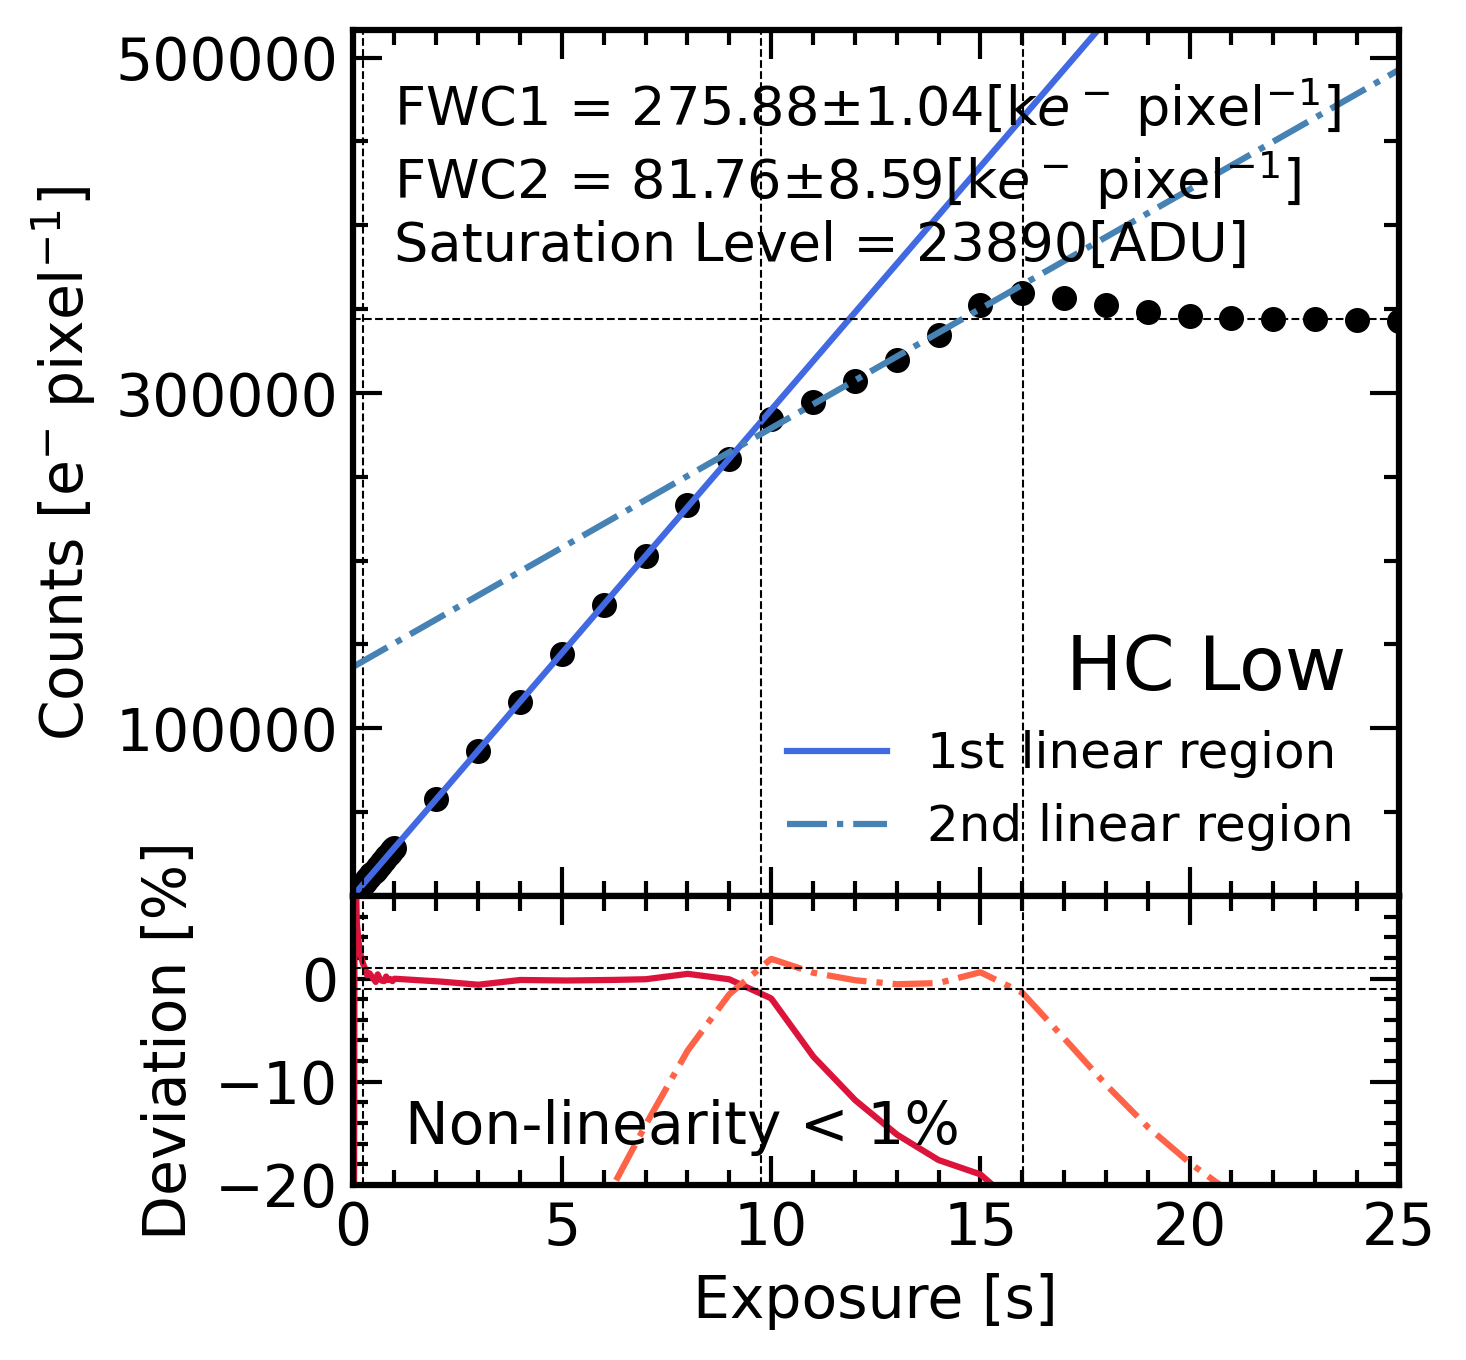

In [249]:
#Gain of CCD
G = ptc_params[0]
Gerr = ptc_perr[0]

#Linear Fitting of linear region
tmax = 25 #t_sorted[-1] #2.5
mask1 = ((10<s_sorted)&(s_sorted<17000)&(t_sorted<tmax))
popt, pcov= curve_fit(linear,t_sorted[mask1],s_sorted[mask1])
perr = np.sqrt(np.diag(pcov))

mask2 = ((19000<s_sorted)&(s_sorted<26000)&(t_sorted<16))
popt2, pcov2= curve_fit(linear,t_sorted[mask2],s_sorted[mask2])
perr2 = np.sqrt(np.diag(pcov2))

linearity = 1 #linearity criteria, %

ts = np.linspace(0,tmax,1000)

#Deviation from linear fitting
dev = (s_sorted-linear(t_sorted,*popt))/linear(t_sorted,*popt)*100
interp = interp1d(t_sorted,dev,kind=1,fill_value='extrapolate')#interpolate.CubicSpline(t,dev,bc_type='natural')

dev2 = (s_sorted-linear(t_sorted,*popt2))/linear(t_sorted,*popt2)*100
interp2 = interp1d(t_sorted,dev2,kind=1)

tol = 0.5
t_low = min(ts[abs(interp(ts)-linearity)<tol]) #lower limit of linearity
t_sat = max(ts[abs(interp(ts)+linearity)<tol]) #upper limit of linearity
t_sat2 = max(ts[abs(interp2(ts)+linearity)<tol])

#Full Well Capacity
FWC = G*(linear(t_sat,*popt)-linear(t_low,*popt))
FWC_err = FWC*np.sqrt((Gerr/G)**2+(perr[1]/(linear(t_sat,*popt)-linear(t_low,*popt)))**2)

FWC2 = G*(linear(t_sat2,*popt2)-linear(t_sat,*popt))
FWC2_err = FWC2*np.sqrt((Gerr/G)**2+(perr2[1]/(linear(t_sat2,*popt2)-linear(t_sat,*popt)))**2)

saturation_counts = int(counts[-1])
saturation_signal = int(signal[-1])
#bias_level = popt[1]

fig = plt.figure(figsize=(4.5,5), dpi = 300)
gs = GridSpec(nrows = 2, ncols =1, height_ratios = [3,1], hspace=0)

ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

#Top - Linearity curve
ax.plot(t_sorted,G*s_sorted,color='k',ls='None',marker='o',ms=5)
ax.plot(ts,G*linear(ts,*popt),color='royalblue',label='1st linear region')
ax.axvline(t_sat,ls='dashed',lw=0.5,color='k')
ax.axvline(t_low,ls='dashed',lw=0.5,color='k')
ax.axhline(G*saturation_signal,ls='dashed',color='k',lw=0.5)
ax.text(tmax*0.95,G*8000,s=f'{acq} {g}',fontsize=18,horizontalalignment='right')

ax.set_xlim(0,tmax)
ax.set_ylim(0,G*saturation_signal*1.5)#G*linear(ts[-1],*popt))
#ax.set_ylim(0,500000)
ax.set_yticks([100000, 300000, 500000])
ax.set_ylabel("Counts [$\\rm e^{-}\;pixel^{-1}$]")
ax.xaxis.set_tick_params(labelbottom=False)

#2nd Linear Regime
ax.plot(ts,G*linear(ts,*popt2),color='steelblue',ls='-.',label='2nd linear region')
ax.axvline(t_sat2,ls='dashed',lw=0.5,color='k')
ax.text(1,G*saturation_signal*1.1,f'FWC1 = {FWC/1e3:.2f}$\\pm${FWC_err/1e3:.2f}[k$e^-\;\\rm pixel^{{-1}}$]\nFWC2 = {FWC2/1e3:.2f}$\\pm${FWC2_err/1e3:.2f}[k$e^-\;\\rm pixel^{{-1}}$]\nSaturation Level = {saturation_counts}[ADU]',
        fontsize = 13)
ax.legend(fontsize=12,loc='lower right')

#Bottom - Deviation from linear response
#ax2.plot(t_sorted,dev, color='crimson',marker='o',ms=3,ls='None')
ax2.plot(ts,interp(ts), color='crimson', ls='-')
ax2.plot(ts,interp2(ts), color='tomato', ls='-.')
ax2.set_ylabel("Deviation [%]")
ax2.set_yticks([0,-10,-20])
ax2.set_xlim(0,tmax)
ax2.set_ylim(-20,8)
ax2.text(tmax*0.05,-16,f"Non-linearity < {linearity}%")
ax2.axvline(t_low,ls='dashed',lw=0.5,color='k')
ax2.axvline(t_sat,ls='dashed',lw=0.5,color='k')
ax2.axvline(t_sat2,ls='dashed',lw=0.5,color='k')
ax2.axhline(linearity,color='k',ls='dashed',lw=0.5)
ax2.axhline(-linearity,color='k',ls='dashed',lw=0.5)
ax2.set_xlabel("Exposure [s]")

plt.savefig(f'C:\\SNU\\Internship\\K-Spec\\논문\\FIgures\FWC\\{acq}\\FWC_{acq}_{g}.png', bbox_inches="tight")

# 4. QE

In [76]:
h = 6.626e-34
c = 2.9979e8

w_pixel = 20e-6 #20um (Pixel size of CCD)
w_sensor = 10e-3#10mm (Sensor size of PMM)

#Power(Measured with PMM)(250-975nm)
P2 = np.array([0.335,0.835,1.405,1.805,2.775,3.685,3.550,3.180,2.945,2.695, 2.415, 2.045, 1.825, 1.575, 1.335, 1.045, 0.865, 0.725, 0.480, 0.470, 2.89,0.235,0.570,0.855,0.600,1.7,1.160])*1e-9
P = np.array([0.415,1.345,2.260,3.335,2.885,2.455,1.875,1.425,0.965,0.685,0.450,0.240,0.775,1.345])*1e-9

In [8]:
acq, g = 'LN','Low'
G = 4.09 #Measured with PTC

#Load unilluminated bias
ubias_path = data_path / f"bias_unilluminated/{acq}_{g}/" 
ubias_list = list(ubias_path.glob('frame*.txt'))
ubias_hdrs, ubias = frame_bulk_loader(ubias_list, label=f'{acq}_{g} / Unilum. bias', header=True)

#Create Master ubias frame
print("== Master Bias frames ==")
ubias_r = np.array(ubias).reshape(-1,Ncol*Nrow)
master_ubias,_,_ = sigma_clipped_stats(ubias_r,axis=0,sigma=3.)
master_ubias = master_ubias.reshape(Nrow,Ncol)
print('Unilluminated bias - Done')

LN_Low / Unilum. bias: 100%|██████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.35it/s]


== Master Bias frames ==
Unilluminated bias - Done


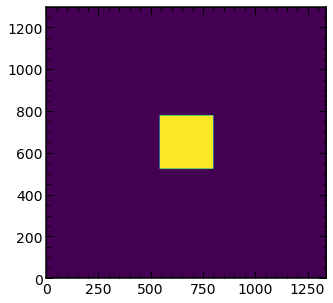

In [77]:
#Masked image (100x100 flat region)
boxsize=256
bh=boxsize//2
xcen = Ncol//2
ycen = Nrow//2
#ycen=Nrow-xcen

mask=np.zeros((Nrow,Ncol))
mask[ycen-bh:ycen+bh,xcen-bh:xcen+bh]=1
plt.imshow(mask,origin='upper',extent=(0,1340,0,1300))

In [78]:
signal = []
wavelength = []
lam_list = list(qe_path.glob('*'))

print("== Load frames ==")
for m, lam_path in enumerate(lam_list):
    #if lam_path.suffix == '.txt': continue
    wavelength.append(int(lam_path.stem[:-2]))
    flat_frame_list = list(lam_path.glob('frame*.txt')) #to exclude readme.txt
    hdrs, flat_tmp = frame_bulk_loader(flat_frame_list, label=f'{acq}_{g} / Wavelength = {lam_path.stem}', header=True)
    
    Ncycle = len(hdrs[hdrs['Exposure']==hdrs['Exposure'][0]]) #the number of iterations per each exposure time
    tarr = np.unique(hdrs['Exposure'].values) #Exposure time array
    
    #Generate master illuminated bias
    tmp_bias = flat_tmp[hdrs['Exposure']==0.].reshape(-1,Ncol*Nrow) #illuminated bias 
    tmp_master_bias,_,_ = sigma_clipped_stats(tmp_bias,axis=0,sigma=3.)
    tmp_master_bias = tmp_master_bias.reshape(Nrow,Ncol)
    
    corr = flat_tmp - tmp_master_bias #True signal
    #Crop central region for ensure uniformity
    corr_clipped = corr[:,ycen-bh:ycen+bh,xcen-bh:xcen+bh] 
    
    #Release memories
    del tmp_bias; gc.collect() 
    del flat_tmp; gc.collect()
    
    #Calculate mean signal
    tmp_signal = []
    for k in range(len(tarr)):
        tmask = (hdrs['Exposure']==tarr[k]) 
        E = np.mean(corr_clipped[tmask],axis=0)
        S = np.mean(E)
        tmp_signal.append(S)
    signal.append(tmp_signal)
signal, wavelength = np.array(signal), np.array(wavelength)

== Load frames ==


LN_High / Wavelength = 950nm: 100%|███████████████████████████████████████████████████| 66/66 [00:13<00:00,  5.03it/s]


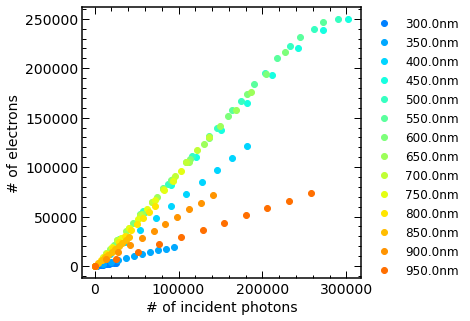

In [100]:
#Photon number flux
dNdt = P/(h*c/(wavelength*1e-9))*(w_pixel/w_sensor)**2

# power error
dP = 0.011*P # measurment error (wand detector)
dP[wavelength<430] = 0.0165*P[wavelength<430]
dP_stab = 0.01e-9
dP = np.sqrt(dP**2 + (dP_stab)**2)

# wavelength error
dlam = 3.5 #nm
dNdt_err = np.sqrt((dP/P)**2 + (dlam/wavelength)**2)

RDN = 115.97 # RDN + GN
G = 4.09  # Gain (from PTC)
dG = 0.02 # Gain error
P_FPN = 0.281e-2 # fixed pattern noise (from PTC)

QE = np.zeros(len(wavelength))
QE_err = np.zeros(len(wavelength))

plt.figure(figsize=(5,5))
for i in range(len(wavelength)):
    mask = np.where((signal[i]<50000) & (signal[i]>0))
    signal_cut, t_cut = signal[i][mask], tarr[mask]/1000
    sigma_phot = np.sqrt(RDN**2 + signal_cut/G + (P_FPN*signal_cut)**2)
    popt, _ = curve_fit(linear,dNdt[i]*t_cut/G,signal_cut)
    QE[i] = popt[0]
    QE_err[i] = np.median(np.sqrt((sigma_phot/signal_cut)**2 + (dG/G)**2 + (dNdt_err[i])**2)) * QE[i]
    plt.plot(dNdt[i]*tarr/1000,G*signal[i],c=cm.jet(wavelength[i]/1200),marker='o',ls='None',label=f"{wavelength[i]}nm")
    
plt.xlabel("# of incident photons") 
plt.ylabel("# of electrons")
plt.legend(frameon=False,fontsize=12,loc='upper left',bbox_to_anchor=(1.0,1.0))

np.save(data_path / 'QE_measured',[wavelength,QE,QE_err])


In [101]:
wavelength,QE,QE_err = np.load(data_path / 'QE_measured.npy')

#Interpolation
lams = np.linspace(290,1000,1000)
fQE = CubicSpline(wavelength,QE*100,bc_type='natural')

## Reference QE curve from Datasheet

In [95]:
ref_qe_path = data_path / "QE_manufacture.csv"
df_ref = pd.read_csv(ref_qe_path,sep=',')
df_ref.sort_values(by='wavelength',axis=0, inplace=True)
ref_lam, ref_QE = df_ref['wavelength'].values, df_ref['QE'].values
fQEref = CubicSpline(ref_lam, ref_QE)

## QE curve

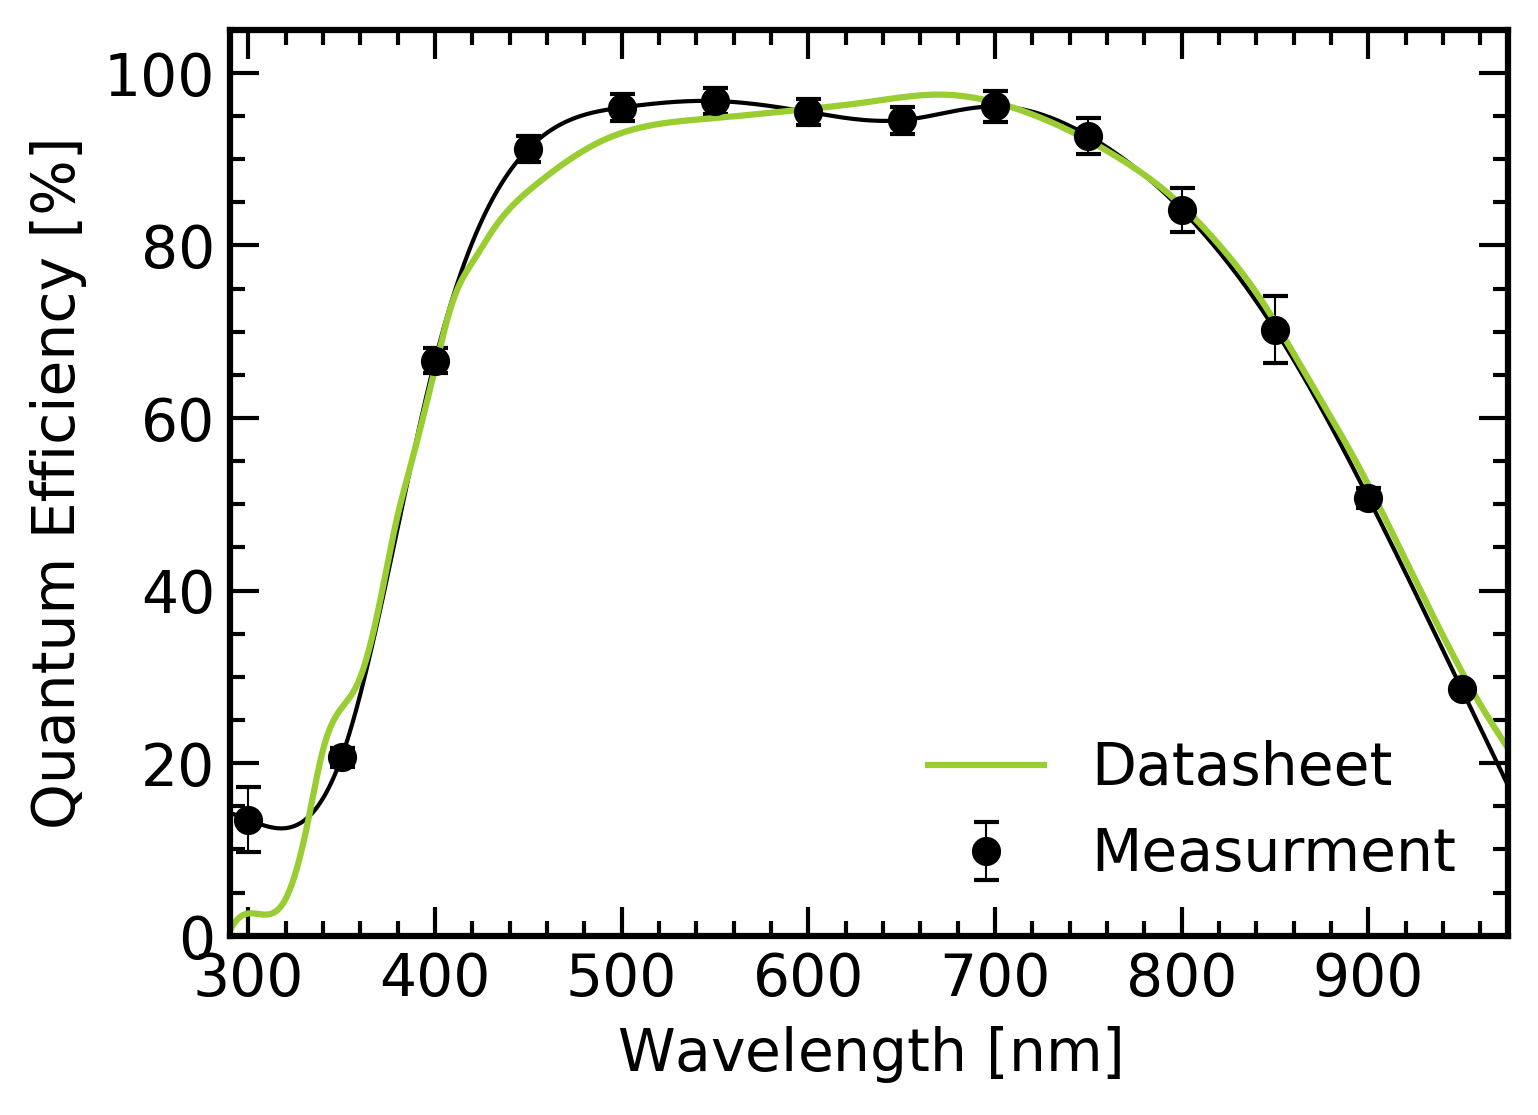

In [102]:
plt.figure(figsize=(5.5,4),dpi=300)
plt.errorbar(wavelength,QE*100,yerr=QE_err*100,ls='None',marker='o',c='k',capsize=3,lw=0.5,label='Measurment')
plt.plot(lams,fQE(lams),color='k',lw=1)
plt.plot(lams,fQEref(lams),color='yellowgreen',label='Datasheet')
plt.xlabel("Wavelength $[\\rm nm]$")
plt.ylabel("Quantum Efficiency [%]")
#plt.axvline(3750,ls='dotted',color='gray')
#plt.axvline(7500,ls='dotted',color='gray')
plt.ylim(0,105)
plt.xlim(290,975)
plt.legend(loc='lower right',fontsize=14)
plt.savefig(fig_path/'QE.png',dpi=300, bbox_inches='tight')

# 5. Perisistence (Residual Bulk Image; RBI)

In [38]:
acq, g = 'LN','Low'
G = 4.09 #Measured with PTC

#Load dark (maintaining under dark for a long time)
dark_path = rbi_path / f"Dark_{acq}_{g}" 
dark_list = list(dark_path.glob('frame*.txt'))
dark_hdrs, dark = frame_bulk_loader(dark_list, label=f'{acq}_{g} / Dark', header=True)

#Create Master ubias frame
print("== Master Dark frames ==")
dark_r = np.array(dark).reshape(-1,Ncol*Nrow)
master_dark,_,_ = sigma_clipped_stats(dark_r,axis=0,sigma=3.)
master_dark = master_dark.reshape(Nrow,Ncol)
print('Dark - Done')

LN_Low / Dark: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.53it/s]


== Master Dark frames ==
Dark - Done


In [39]:
acq, g = 'LN','Low'
G = 4.09 #Measured with PTC

#Load dark (maintaining under dark for a long time)
ubias_path = rbi_path / f"uBias_{acq}_{g}" 
ubias_list = list(ubias_path.glob('frame*.txt'))
ubias_hdrs, ubias = frame_bulk_loader(ubias_list, label=f'{acq}_{g} / Unilum. Bias', header=True)

#Create Master ubias frame
print("== Master Bias frames ==")
ubias_r = np.array(ubias).reshape(-1,Ncol*Nrow)
master_ubias,_,_ = sigma_clipped_stats(ubias_r,axis=0,sigma=3.)
master_ubias = master_ubias.reshape(Nrow,Ncol)
print('uBias - Done')

LN_Low / Unilum. Bias: 100%|██████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.46it/s]


== Master Bias frames ==
uBias - Done


In [40]:
lam = 600
acq = 'LN'
g = 'Low'

batch_list = list(rbi_path.glob(f'{lam}nm_{acq}_{g}/frame*.txt'))

hdrs, flat = frame_bulk_loader(batch_list,label=f'{acq}_{g} / Flat', header=True)
Ncycle = len(hdrs[hdrs['Exposure']==hdrs['Exposure'][0]])

LN_Low / Flat: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.47it/s]


Text(0.5, 0, 'After Illumination [min]')

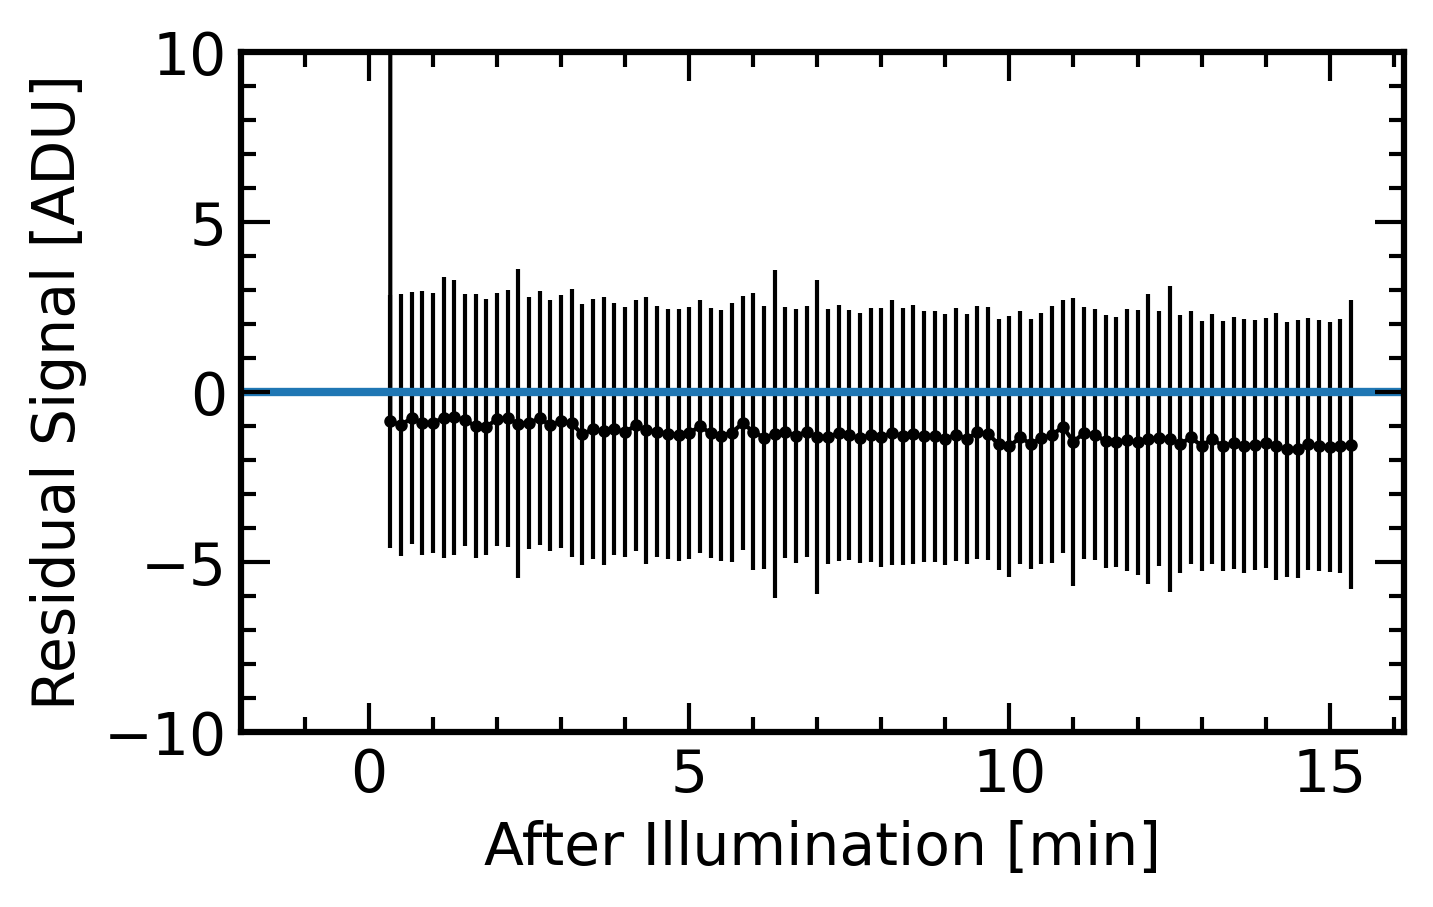

In [54]:
plt.figure(figsize=(6,3.5),dpi=300)
plt.errorbar((t-70)/60,signal,yerr=noise,c='k',marker='o',ms=2,lw=1,zorder=0)
plt.axhline(0,ls='-',lw=2,zorder=1)
plt.ylim(-10,10)
plt.ylabel("Residual Signal [ADU]")
plt.xlabel("After Illumination [min]")
#plt.savefig(fig_path / 'Persistence.png',dpi=300,bbox_inches='tight')
#plt.text(15,7000,"1s exposure / 600nm / -55$^{\\circ}C$")